**By: Ed Trujillo**

**Sample Code**

**Donor Dataset Project**

**Goal: Analyze donor dataset and predict people who are more likely to be donors for U.S. arts and cultural organizations**

# Data preprocessing

Note: Data comes from museum survey questions so most of the variables are shown as numbers (e.g., 'q21')

In [2]:
from google.colab import files, drive
import io
import tensorflow as tf
import numpy as np
import pandas as pd
import csv
from collections import Counter
from random import seed, random

**uploading data**

In [3]:
# used google colab (Python environment)
drive.mount('/content/drive') # attaching my google drive to this notebook
path1 = "/content/drive/My Drive/sample_code/original data.csv"
missing_values = [" ", "99"]
df = pd.read_csv(path1, encoding="utf8", na_values = missing_values)
print('Number of records and columns: ', df.shape)

Mounted at /content/drive


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (227,229,318,338,392,410,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,464,500,518,536,550,551,552,553,554,555,556,557,558,559,560,561,588,589,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,616,618,620,621,622,623,624,625,626,627,628,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,662,663,674,675,676,677,678,679,680,681,682,688,691) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Number of records and columns:  (123757, 693)


## **Creating a fake dataset**

comes from randomizing original dataset values to protect original version

In [ ]:
def rand_col_vals(df_var,n_values):
  """Takes a dataframe column (df_var) and returns a list of random column values of lenght(n_values)."""
  col_vals = list(df_var)
  rdm_vals = []
  for val in range(1,n_values + 1):
    rdm_val = random.choice(col_vals)
    rdm_vals.append(rdm_val)
  return rdm_vals

In [ ]:
# using the function I created, I create a list of random values for each dataframe column
# each element in the list represents a list of random valuess for each dataframe column
columns = list(df.columns)
all_col_rand_vals = []
for var in columns:
  rdm_vals = rand_col_vals(df[var],123000)
  all_col_rand_vals.append(rdm_vals)

In [ ]:
# creating new dataframe
mydict = dict(zip(columns, all_col_rand_vals)) # zipping columns names with corresponding random col vals
df = pd.DataFrame(data=mydict)

In [ ]:
print(df.shape,'\n')
df.head(5)

(123000, 693) 



,record,uuid,date,markers,status,q1_1,q1_2,q1_3,q1_4,q1_5,q1_6,q1_7,q1_8,q1_9,q1_10,q1_11,q1_12,q1_13,q1_14,q1_15,q1_16,q1_90,q1_99,q1_90_TEXT,q2_1,q2_2,q2_3,q2_4,q2_5,q2_6,q2_7,q2_8,q2_90,q2_99,q2_90_TEXT,q3_1,q3_2,q3_3,q3_4,q3_5,...,q46_6,q46_7,q46_8,q46_90,q46_90_TEXT,q47,vlist,qtime,start_date,vdropout,list,survey,EndDate,fielddate,Num_date,demogans,timer,Agecat,age,agegen,censusrace,CityName,CountyName,StateName,StateAbbr,MSA,MSACode,REGION4,REGION9,METRO,source,ASID,NORCweight,meaninc,memberORsubscriber,CBSA2018Code,WEIGHT_Comb,weightALL,MetroMicroRecode,Q12binary
0,118479.0,7sfuk6vm3tuh5fa5,05/01/2020 09:19,"qualified,20200501_19:05_v4,/Overall Infinite ...",Qualified,Socialized online or by phone,Spent time outdoors,"NO TO: Listened to music, or watched a musical...",Did something musical myself,Played a videogame or online game,NO TO: Watched a movie or TV series,Watched a live-streaming event or performance,"Read a book, story, or poem",Listened to a podcast or audiobook,"Participated in prayer, meditation, or counseling",NO TO: Learned something new or took an online...,NO TO: Shared a playlist I created,NO TO: Watched sports,Volunteered or donated to help during Covid-19,NO TO: Participated in a live interactive even...,NO TO: Used social media to tell a story,NO TO: Other (please specify):,NO TO: None of these,NaN,Dancing,"NO TO: Painting, drawing, sculpting, printmaki...",NO TO: Photography or photo editing,Filmmaking or videomaking,NO TO: Designing something,Making something by hand,"Creative writing, writing poetry, journaling",NO TO: Cooking a new recipe or baking something,NO TO: Other (please specify):,NO TO: None of these,Gardening,Sang alone or with others,Played an instrument,Listened to music,Watched a live or recorded concert or performance,NO TO: Participated in an interactive online m...,...,NaN,NaN,NaN,NaN,NaN,2.0,US Orgs (list=usorgs),1700.02,05/09/2020 08:22,NaN,usorgs,List survey,5/1/2020,5/4/2020,13807929600,7.0,21.5,NaN,63.0,Silent (1928-45),White/Caucasian,Bel Air,Bexar,Vermont,California,NaN,NaN,South,South Atlantic,Metro Area,NaN,NaN,NaN,74999.5,Member or Subscriber,"Chicago-Naperville-Elgin, IL-IN-WI",0.216495,0.085134,Metropolitan Statistical Area,Yes - done a digital activity
1,141683.0,0sgeqx7sn0qjts1a,05/09/2020 09:17,"qualified,20200501_19:05_v4,/Overall Infinite ...",Qualified,NO TO: Socialized online or by phone,Spent time outdoors,"Listened to music, or watched a musical perfor...",Did something musical myself,NO TO: Played a videogame or online game,Watched a movie or TV series,NO TO: Watched a live-streaming event or perfo...,"Read a book, story, or poem",NO TO: Listened to a podcast or audiobook,"NO TO: Participated in prayer, meditation, or ...",NO TO: Learned something new or took an online...,NO TO: Shared a playlist I created,NO TO: Watched sports,NO TO: Volunteered or donated to help during C...,Participated in a live interactive event online,NO TO: Used social media to tell a story,Other (please specify):,NO TO: None of these,NaN,NO TO: Dancing,"NO TO: Painting, drawing, sculpting, printmaki...",NO TO: Photography or photo editing,NO TO: Filmmaking or videomaking,NO TO: Designing something,Making something by hand,"NO TO: Creative writing, writing poetry, journ...",Cooking a new recipe or baking something,NO TO: Other (please specify):,NO TO: None of these,NaN,Sang alone or with others,NaN,Listened to music,Watched a live or recorded concert or performance,NO TO: Participated in an interactive online m...,...,Online educational programs or workshops,NaN,NaN,NaN,NaN,4.0,US Orgs (list=usorgs),1287.91,05/01/2020 10:58,NaN,usorgs,List survey,5/5/2020,5/2/2020,13807929600,3.0,31.0,NaN,NaN,Silent (1928-45),White/Caucasian,Cary,Cuyahoga,Illinois,NaN,"Tampa-St. Petersburg-Clearwater, FL","Bremerton, WA",NaN,New England,NaN,NaN,NaN,NaN,74999.5,Not a member or subscriber,"Chicago-Naperville-Elgin, IL-IN-WI",0.010184,0.007152,Metropolitan Statistical Area,No - has not done a digital ac

## Filtering

In [ ]:
# dropping entire missing records
# filtering out Canadian resident records
# keeping people with primary residency in U.S.

df = df.dropna(how='all') #drops entire missing records
df = df[df['q21'] != 'Not sure'] # only want yes and no responses to those who donated
df = df[df['q35'] == 'In the United States'] # only people w/ primary residence in US 
print('Number of records and columns: ', df.shape)

Number of records and columns:  (114227, 693)


In [ ]:
# keeping records where people know that they
# have donated during Covid-19 and those who know
# that they have not donated during Covid-19
# variable meaning: "Q22. What types of causes or organizations have you donated money to?"

yes = 'I’ve donated to this during Covid-19 (in 2020)'
df  =  df [   (df.q22_a_1 == yes) | (df.q22_a_2 == yes) | (df.q22_a_99 == yes) |
              (df.q22_b_1 == yes) | (df.q22_b_2 == yes) | (df.q22_b_99 == yes) |
              (df.q22_c_1 == yes) | (df.q22_c_2 == yes) | (df.q22_c_99 == yes) |
              (df.q22_d_1 == yes) | (df.q22_d_2 == yes) | (df.q22_d_99 == yes) |
              (df.q22_e_1 == yes) | (df.q22_e_2 == yes) | (df.q22_e_99 == yes) |
              (df.q22_f_1 == yes) | (df.q22_f_2 == yes) | (df.q22_f_99 == yes) |
              (df.q22_g_1 == yes) | (df.q22_g_2 == yes) | (df.q22_g_99 == yes) |
              (df.q22_h_1 == yes) | (df.q22_h_2 == yes) | (df.q22_h_99 == yes) |
              (df.q22_90_1 == yes)| (df.q22_90_2 == yes)| (df.q22_90_99 == yes)|
              (df.q21 == 'No')  ] # means I have not donated to arts & cultural orgs.
df.shape

(99473, 693)

## Removing variables

In [ ]:
# removing mostly administrative vars that I do not need

vars_drop = ['record','uuid','date','markers','status','qtime','start_date',
              'survey','EndDate', 'fielddate','Num_date','demogans',
              'StateAbbr','MSA','source','ASID','NORCweight','meaninc',
              'CBSA2018Code','WEIGHT_Comb','MetroMicroRecode',
              'vdropout','timer','qMODULES','q40_CAN','MSACode',
              'vlist','list','q37']
df = df.drop(vars_drop, axis=1)

In [ ]:
# removing columns(questions) not directed at everyone & text columns
# these are mostly follow up survey questions

# all columns that qualify
unimp_vars = ['text','recode','sum', 'q40_CAN',
              'q3_','q4_','q8_','q9_','q9','q10_',
              'q12_','q13_','q14','q15_','q16_','q22_',
              'q23_','q24_','q26','q27_','q38_',
              'q39_','q43_','q44_','q45_','q46_',
              'q36','agegen']

# using this method because column variables contain a pattern
# they start with the variable names listed in the above list
all_vars = list(df.columns)
for unimp_var in unimp_vars:
  for df_var in all_vars:
    if unimp_var in df_var.lower():
      df = df.drop([df_var], axis=1)  
df.shape

(99473, 188)

In [ ]:
#pd.set_option('display.max_rows', None)
print('Number of records and columns: ', df.shape,'\n')
print("{} {:>18}".format('Variable', 'Type'))
print('---------------------------------')
df.dtypes

Number of records and columns:  (99473, 188) 

Variable               Type
---------------------------------


q1_1                   object
q1_2                   object
q1_3                   object
q1_4                   object
q1_5                   object
                       ...   
REGION9                object
METRO                  object
memberORsubscriber     object
weightALL             float64
Q12binary              object
Length: 188, dtype: object

## Changing variable types

In [ ]:
# converting to numeric variables

# list of all variables that need to be numeric
all_vars = list(df.columns)
num_vars = ['q5','q17','q18','q19','q37','q47','age'] # all numeric variables start with these characters
full_num_vars = [] # creating a list of all numeric variables for next block of code

# converting variables to numeric type
for num_var in num_vars:
  for all_var in all_vars:
    if num_var in all_var:
        full_num_vars.append(all_var) # creating a list with full numeric variable names
        df[all_var] = pd.to_numeric(df[all_var], errors='coerce').astype('Int64')

In [ ]:
# converting to categorical variables

# list of all variables that need to be categorical
cat_vars = list(set(all_vars) - set(full_num_vars))  # variables that are not numeric are categorical

# converting to categorical type
for cat_var in cat_vars:
  for all_var in all_vars:
    if cat_var == all_var:
        df[all_var] = df[all_var].astype('category') 

In [ ]:
# another numeric variable 
df['weightALL'] = pd.to_numeric(df['weightALL']) 

In [ ]:
#pd.set_option('display.max_rows', None)
print('Number of records and columns: ', df.shape,'\n')
print("{} {:>18}".format('Variable', 'Type'))
print('---------------------------------')
df.dtypes

Number of records and columns:  (99473, 188) 

Variable               Type
---------------------------------


q1_1                  category
q1_2                  category
q1_3                  category
q1_4                  category
q1_5                  category
                        ...   
REGION9               category
METRO                 category
memberORsubscriber    category
weightALL              float64
Q12binary             category
Length: 188, dtype: object

## Removing missing values

In [ ]:
# removing records w/ containing any missing values
df = df.dropna()
df.shape

(4369, 188)

## Coding values

In [ ]:
# explanation for my following coding

print('Variable values need to be 0 if person did not do the action and 1 if person did the action.')
print('These variables are yes/no type variables.','\n','Examples:')
print('\n','Variable "q1_1" categories & count')
print('---------------------------------------')
print(df['q1_1'].value_counts())

print('\n','Variable "q1_2" categories & count')
print('---------------------------------------')
print(df['q2_1'].value_counts())

#variable values need to be 0 if person did not do the action 
# and 1 if person did the action

Variable values need to be 0 if person did not do the action and 1 if person did the action.
These variables are yes/no type variables. 
 Examples:

 Variable "q1_1" categories & count
---------------------------------------
Socialized online or by phone           3878
NO TO: Socialized online or by phone     491
Name: q1_1, dtype: int64

 Variable "q1_2" categories & count
---------------------------------------
NO TO: Dancing    3612
Dancing            757
Name: q2_1, dtype: int64


**creating a dictionary that will be used to recode all column values**

In [ ]:
df2 = df 

In [ ]:
# recoding variables containing 'yes' or 'no' type values

# list of variables that do not contain such values
other_lst = ['q21', 'q29',	'q30',	'q31',	'q32',	'q35',	'q37',	'q38',	
              'q40',	'q41',	'q42',	'q47',	'vlist',	'list',	
              'Agecat',	'age',	'agegen',	'censusrace',	'CityName',	'CountyName',
              'StateName',	'MSACode',	'REGION4',	'REGION9',	
              'METRO',	'memberORsubscriber',	'Q12binary']

# variables containing 'yes' or 'no' type values are those non-numeric variables and
# those found in the other_lst I created
notTo_vars = list( set(all_vars) - set(other_lst) - set(full_num_vars) )     # these are the variables that need to be coded as 0's and 1's

In [ ]:
# ROUND 1
# variables that need to be coded as 0's and 1's
# if variable value contains 'No to' then it is a 0
# otherwise it is a 1

mydict = { } 
for cat_var in notTo_vars: 
  try:
    uni_vals = list(df[cat_var].unique()) # finds unique categories in variable
    mydict[cat_var] = {} 

    for uni_val in uni_vals: # appends category with '0' or '1' in dict
      if 'NO TO' in uni_val:
        mydict[cat_var][uni_val] = 0
      else:
        mydict[cat_var][uni_val] = 1
        
  except:
    pass

In [ ]:
# ROUND 2
# variables that need to be coded as 0's and 1's
# if variable value contains a 'No' then it is coded as 0
# otherwise it is coded as 1

# variables  containing 'No' as part of a value
yes_no = ['q21','q38',	'memberORsubscriber', 'Q12binary']

# adding to dict
for cat_var in yes_no:
  try:
    uni_vals = list(df[cat_var].unique()) # finds unique categories in variable
    mydict[cat_var] = {} 
    for uni_val in uni_vals: # appends category with '0' or '1' in dict
      if 'No' in uni_val:
        mydict[cat_var][uni_val] = 0

      else:
        mydict[cat_var][uni_val] = 1
  except:
    pass

In [ ]:
print("This is a sample of the dictionary that will be used to code all column values")
print('----------------------------------------------------------------------------','\n')
c = 0
for key, value in mydict.items():
  c = c + 1
  if c >= 15:
    continue
  else:
    print('{}----{}'.format(key,value))

This is a sample of the dictionary that will be used to code all column values
---------------------------------------------------------------------------- 

q1_16----{'Used social media to tell a story': 1, 'NO TO: Used social media to tell a story': 0}
q6_4----{'Connection with other people': 1, 'NO TO: Connection with other people': 0}
q25_8----{'NO TO: Go to a children’s museum': 0, 'Go to a children’s museum': 1}
q28_6----{'NO TO: More frequent new works or exhibits': 0, 'More frequent new works or exhibits': 1}
q20_15----{'Deal with financial and economic problems': 1, 'NO TO: Deal with financial and economic problems': 0}
q34_2----{'NO TO: I was a subscriber or season-ticket holder to an arts and culture organization': 0, 'I was a subscriber or season-ticket holder to an arts and culture organization': 1}
q7_16----{'Read books/literature': 1, 'NO TO: Read books/literature': 0}
q11_99----{'NO TO: None of these': 0, 'None of these': 1}
q20_8----{'Bring people of different backgrou

In [ ]:
# using created dictionry to code my variable values
df2 = df2.replace(mydict)
df2.head(3)

,q1_1,q1_2,q1_3,q1_4,q1_5,q1_6,q1_7,q1_8,q1_9,q1_10,q1_11,q1_12,q1_13,q1_14,q1_15,q1_16,q1_90,q1_99,q2_1,q2_2,q2_3,q2_4,q2_5,q2_6,q2_7,q2_8,q2_90,q2_99,q5a,q5b,q5c,q5d,q5e,q5f,q5g,q6_1,q6_2,q6_3,q6_4,q6_5,...,q28_3,q28_4,q28_5,q28_6,q28_7,q28_8,q28_9,q28_10,q28_11,q28_12,q28_90,q28_99,q34_1,q34_2,q34_3,q34_4,q34_5,q34_99,q29,q30,q31,q32,q35,q38,q40,q41,q42,q47,Agecat,age,censusrace,CityName,CountyName,StateName,REGION4,REGION9,METRO,memberORsubscriber,weightALL,Q12binary
33,1,1,0,1,0,0,0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,3,5,1,4,1,3,1,1,1,0,1,0,...,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Yes,No,Not sure,"No, there has been no change to my income",In the United States,0,Master’s degree,Not working – other (please specify):,"$50,000–$99,999",2,50-64,76,White/Caucasian,Milwaukee,Dane,New Jersey,Northeast,Mountain,Metro Area,1,0.073988,0
80,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,0,3,4,3,2,4,3,2,0,0,0,1,0,...,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,Yes,No,No,"No, there has been no change to my income",In the United States,0,Bachelor’s degree,Working – as a paid employee,"$100,000–$149,999",2,35-49,70,Black/African American,Indianapolis,Oakland,California,South,South Atlantic,Metro Area,0,0.003937,1
93,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,2,3,3,5,3,2,1,0,0,0,0,0,...,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,Yes,No,No,"No, there has been no change to my income",In the United States,0,Master’s degree,Working – as a paid employee,Prefer not to answer,2,18-34,76,White/Caucasian,Nashua,Los Angeles,California,South,Pacific,Metro Area,1,0.529651,1


## Dummy variables

In [ ]:
# creating dummy variables
dumvars = ['Agecat','q35', 'q40', 'q41', 'q42','censusrace','q29','q30','q31','q32','REGION4','REGION9','METRO'] 
df2 = pd.get_dummies(df2, columns=dumvars, drop_first=True)
pd.set_option('display.max_columns', None)

print('Number of records and columns: ', df2.shape)
df2.head(3)
# some geographic variables are not created into dummy vars because they are used as potential model predictors

Number of records and columns:  (4369, 226)


,q1_1,q1_2,q1_3,q1_4,q1_5,q1_6,q1_7,q1_8,q1_9,q1_10,q1_11,q1_12,q1_13,q1_14,q1_15,q1_16,q1_90,q1_99,q2_1,q2_2,q2_3,q2_4,q2_5,q2_6,q2_7,q2_8,q2_90,q2_99,q5a,q5b,q5c,q5d,q5e,q5f,q5g,q6_1,q6_2,q6_3,q6_4,q6_5,q6_6,q6_7,q6_8,q6_9,q6_10,q6_90,q6_99,q7_1,q7_2,q7_3,q7_4,q7_5,q7_6,q7_7,q7_8,q7_9,q7_10,q7_11,q7_12,q7_13,q7_14,q7_15,q7_16,q7_17,q7_18,q7_19,q7_20,q7_21,q7_22,q7_23,q7_24,q7_25,q7_26,q7_27,q7_28,q7_29,q7_30,q7_31,q7_32,q7_33,q7_34,q7_99,q11_1,q11_2,q11_3,q11_4,q11_5,q11_6,q11_7,q11_8,q11_9,q11_10,q11_90,q11_99,q18,q17,q19a,q19b,q19c,q19d,q19e,q19f,q20_1,q20_2,q20_3,q20_4,q20_5,q20_6,q20_7,q20_8,q20_9,q20_10,q20_11,q20_12,q20_13,q20_14,q20_15,q20_90,q20_99,q21,q25_1,q25_2,q25_3,q25_4,q25_5,q25_6,q25_7,q25_8,q25_9,q25_10,q25_11,q25_12,q25_13,q25_90,q25_99,q48_1,q48_2,q48_3,q48_4,q48_5,q48_6,q48_7,q48_8,q48_9,q48_10,q48_90,q28_1,q28_2,q28_3,q28_4,q28_5,q28_6,q28_7,q28_8,q28_9,q28_10,q28_11,q28_12,q28_90,q28_99,q34_1,q34_2,q34_3,q34_4,q34_5,q34_99,q38,q47,age,CityName,CountyName,StateName,memberORsubscriber,weightALL,Q12binary,Agecat_35-49,Agecat_50-64,Agecat_65+,q40_Bachelor’s degree,q40_High school graduate (high school diploma or the equivalent GED),q40_Less than high school/GED,q40_Master’s degree,q40_Professional or doctorate degree,"q40_Some college, no degree",q41_Not working – looking for work,q41_Not working – on temporary layoff from a job,q41_Not working – other (please specify):,q41_Not working – retired,q41_Working – as a paid employee,q41_Working – self-employed,"q42_$150,000–$199,999","q42_$200,000 or more","q42_$25,000–$49,999","q42_$50,000–$99,999",q42_Prefer not to answer,"q42_Under $25,000",censusrace_Black/African American,censusrace_Native American,censusrace_Other race,censusrace_Two+ races,censusrace_White/Caucasian,q29_Not sure / It’s complicated,q29_Prefer not to answer,q29_Yes,q30_No,q30_Prefer not to answer,q30_Sometimes,q30_Yes,q31_Not sure,q31_Prefer not to answer,q31_Yes,q32_Prefer not to answer,"q32_Yes, I have no income now","q32_Yes, I still have some income but less than before",REGION4_Northeast,REGION4_South,REGION4_West,REGION9_East South Central,REGION9_Middle Atlantic,REGION9_Mountain,REGION9_New England,REGION9_Pacific,REGION9_South Atlantic,REGION9_West North Central,REGION9_West South Central,METRO_Non-Metro Area
33,1,1,0,1,0,0,0,1,0,0,1,0,0,1,1,1,1,0,0,0,0,0,0,1,0,1,0,0,3,5,1,4,1,3,1,1,1,0,1,0,1,0,0,0,0,0,0,1,1,1,1,1,1,0,1,0,0,0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,1,1,0,1,1,0,0,5,5,2,5,3,3,3,3,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,76,Milwaukee,Dane,New Jersey,1,0.073988,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
80,1,1,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,1,0,0,3,4,3,2,4,3,2,0,0,0,1,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,1,1,1,1,1,0,0,0,1,0,1,0,1,1,0,0,1,0,0,4,4,3,5,2,5,3,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,1,1,1,0,0,1,0,1,1,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,2,70,Indianapolis,Oakland,California,0,0.003937,1,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
93,1,1,1,0,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,2,3,3,5,3,2,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,1,1,1,0,1,0,1,0,0,1,0,0,5,5,2,5,1,2,4,1,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,2,76,Nashua,Los Angeles,California,1,0.529651,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [ ]:
# data quality check
print('Descriptive summary','\n')
print('---------------------------------------------------------------------------')
df2.describe().T

Descriptive summary 

---------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
q1_1,4369.0,0.887617,0.315873,0.0,1.0,1.0,1.0,1.0
q1_2,4369.0,0.877546,0.327847,0.0,1.0,1.0,1.0,1.0
q1_3,4369.0,0.758755,0.427888,0.0,1.0,1.0,1.0,1.0
q1_4,4369.0,0.262074,0.439813,0.0,0.0,0.0,1.0,1.0
q1_5,4369.0,0.319524,0.466346,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...
REGION9_Pacific,4369.0,0.165484,0.371659,0.0,0.0,0.0,0.0,1.0
REGION9_South Atlantic,4369.0,0.192493,0.394303,0.0,0.0,0.0,0.0,1.0
REGION9_West North Central,4369.0,0.066606,0.249366,0.0,0.0,0.0,0.0,1.0
REGION9_West South Central,4369.0,0.089723,0.285817,0.0,0.0,0.0,0.0,1.0


**exporting clean dataset version as an excel file**

In [ ]:
# exporting clean dataset version as an excel file
#df2.to_csv('cleaned master dataset.csv') 
#files.download('cleaned master dataset.csv')

# Exploratory Analysis

In [ ]:
import matplotlib.pyplot as plt
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt; plt.rcdefaults()

## Descriptive summary

**analyzing questions where survey-takers could only select one option**

In [ ]:
vars = list(df2.columns)
# all desired vars start w/ the following from the list
quest = ['q21','q5','q17','q18','q19','q47','Agecat','q40','q41','q42','REGION9','age'] 


# creating a list of all one anwers questions
one_ans_scale_qs = []
for var in quest:
  for full_var in vars:
    if var in full_var:
      one_ans_scale_qs.append(full_var)

one_ansQs_df = df2[one_ans_scale_qs]

In [ ]:
pd.set_option('display.max_rows', None)
print('Descriptive summary for questions where survey-takers could only select one option.','\n')
print('---------------------------------------------------------------------------')
one_ansQs_df.describe().T

Descriptive summary for questions where survey-takers could only select one option. 

---------------------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
q21,4369.0,0.934081,0.248169,0.0,1.0,1.0,1.0,1.0
q5a,4369.0,3.542916,0.996813,1.0,3.0,4.0,4.0,5.0
q5b,4369.0,3.125658,0.952154,1.0,3.0,3.0,4.0,5.0
q5c,4369.0,3.184939,0.968904,1.0,3.0,3.0,4.0,5.0
q5d,4369.0,3.158846,1.088333,1.0,3.0,3.0,4.0,5.0
q5e,4369.0,2.972763,0.999056,1.0,3.0,3.0,4.0,5.0
q5f,4369.0,2.795605,0.891874,1.0,2.0,3.0,3.0,5.0
q5g,4369.0,2.618677,1.095353,1.0,2.0,2.0,3.0,5.0
q17,4369.0,4.220645,0.957343,1.0,4.0,5.0,5.0,5.0
q18,4369.0,4.407874,0.792185,1.0,4.0,5.0,5.0,5.0


**functions as another data quality check**

In [ ]:
print('exporting data summary into an Excel file for the following block')

exporting data summary into an Excel file for the following block


In [ ]:
# exporting data summary into an Excel file ----easier to look at
# output will be the following:
# original column name         (excel column 1)
# categories for each column   (excel column 2)
# counts for each category     (excel column 3)
# percentage for each category (excel column 4)

geo_demo = ['CityName','CountyName','StateName']
vars = list(df2.columns)
with open('cleaned entire data_descriptive_summary.csv', 'w') as csv_file: # by using 'with open', I do not have to close the file
  first_line = ['variable/question', 'labels', 'count', 'percentage']
  csv_writer = csv.writer(csv_file, delimiter=',')
  csv_writer.writerow(first_line)
  for var in vars:
    try: # if a variable contains coded values
      labels = mydict[var]
      c = Counter(df2[var])  # for calculating %
      s = sum(c.values())    # for calculating %
      d = { elem: round ( (count/s), 2 ) for elem, count in c.items() } # for calculating %
      rec = [var, labels, Counter(df2[var]),d] # record exporting to Excel
      csv_writer = csv.writer(csv_file, delimiter=',')
      csv_writer.writerow(rec)
    except: # if a variable does not contain coded values
      c = Counter(df2[var]) 
      s = sum(c.values())   
      d = { elem: round ( (count/s), 2 ) for elem, count in c.items() } # for calculating %
      rec = [var, '', Counter(df2[var]),d]
      csv_writer = csv.writer(csv_file, delimiter=',')s
      csv_writer.writerow(rec)

files.download('cleaned entire data_descriptive_summary.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Bar plots

comparing donors to non-donors

In [ ]:
# creating labels for all numeric variables 
# will be used when creating bar plots

labels = [
                'q5a. Compared to before the pandemic began, how are you feeling these days? Worried or afraid.',
                'q5b. Compared to before the pandemic began, how are you feeling these days? Lonely.',
                'q5c. Compared to before the pandemic began, how are you feeling these days? Sad or depressed.',
                'q5d. Compared to before the pandemic began, how are you feeling these days? Bored.',
                'q5e. Compared to before the pandemic began, how are you feeling these days? Angry.',
                'q5f. Compared to before the pandemic began, how are you feeling these days? Calm.',
                'q5g. Compared to before the pandemic began, how are you feeling these days? Connected to others.',
       '17. During a crisis like Covid-19, how important or unimportant are arts & culture organizations to you?',              
       '18. Before Covid-19, how important or unimportant were arts & culture organizations to you?',       
'q19a. I hope the arts & culture organizations in my area will change after the pandemic to be more relevant to people like me.',
'q19b. The arts & culture organizations in my area are really struggling financially because of Covid-19.',
'q19c. I’ve seen or heard about an arts or cultural organization in my area helping our community during the crisis in some specific way.',
'q19d. During this crisis, we should support other kinds of nonprofit organizations in my area before supporting arts & culture organizations.',
'q19e. I’m hearing a lot from arts & culture organizations during Covid-19, via emails, social media, etc. [KEEP e and f together]',
'q19f. I wish I were hearing more from arts & culture organizations during Covid-19, via emails, social media, etc. [KEEP FOLLOWING e]',
'q47. To what extent have you begun to make plans to attend any arts & culture experiences after the lockdowns?',
'Age'
 ]

In [ ]:
# creating dictionary with var name as key and label as val
zip_iterator = zip(full_num_vars, labels) # full_num_vars was created in the preprocessing stage -contains all numeric variables as a list
varsWnolabels = dict(zip_iterator)
varsWnolabels 

{'age': 'Age',
 'q17': '17. During a crisis like Covid-19, how important or unimportant are arts & culture organizations to you?',
 'q18': '18. Before Covid-19, how important or unimportant were arts & culture organizations to you?',
 'q19a': 'q19a. I hope the arts & culture organizations in my area will change after the pandemic to be more relevant to people like me.',
 'q19b': 'q19b. The arts & culture organizations in my area are really struggling financially because of Covid-19.',
 'q19c': 'q19c. I’ve seen or heard about an arts or cultural organization in my area helping our community during the crisis in some specific way.',
 'q19d': 'q19d. During this crisis, we should support other kinds of nonprofit organizations in my area before supporting arts & culture organizations.',
 'q19e': 'q19e. I’m hearing a lot from arts & culture organizations during Covid-19, via emails, social media, etc. [KEEP e and f together]',
 'q19f': 'q19f. I wish I were hearing more from arts & culture or

**automating plot creation**

**every plot is grouped by donors and non-donors**

q1_16 
 -------------------------------------------


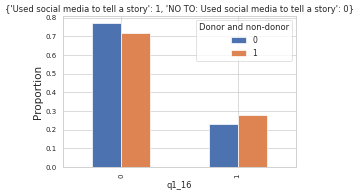



q6_4 
 -------------------------------------------


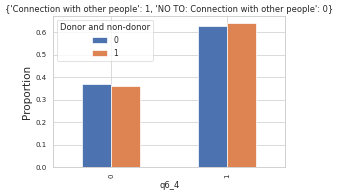



q25_8 
 -------------------------------------------


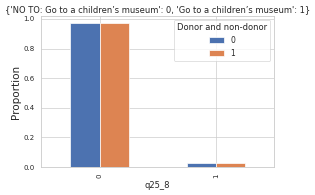



q28_6 
 -------------------------------------------


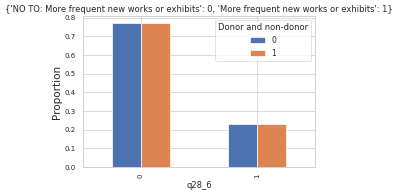

In [ ]:
# note: only plotting a few columns as an example

geo_demo = ['CityName','CountyName','StateName'] # skipping these variables
vars = list(set(df2.columns) - set(geo_demo))
c = 0
for numvar in vars: 
  c = c + 1
  if c == 5:
    break
  else:
    try: 
      print(numvar,'\n','-------------------------------------------')
      ct = pd.crosstab(df2[numvar], df2['q21']).apply(lambda r: round((r/r.sum()),2), axis=0) # crosstab
      # plotting stacked bar graphs
      plt.rcParams['figure.dpi'] = 50
      sns.set(style="whitegrid") 
      ct.plot.bar(stacked=False)

      plt.title(mydict[numvar]) # using dic to add actual question as the title
      plt.legend(title='Donor and non-donor')
      plt.ylabel('Proportion', size=15)

      plt.xticks(size=10)
      plt.yticks(size=10)
      plt.show()
      print('\n')

    except:
      try:
        plt.title(varsWnolabels[numvar]) # using dic to add actual question as the title
        plt.legend(title='Donor and non-donor')
        plt.ylabel('Proportion', size=15)
        plt.xlabel('Question Categories')

        plt.xticks(size=10)
        plt.yticks(size=10)
        plt.show()
        print('\n')
      except:
        pass

## Stacked bar graphs 
comparing donors to non-donors

**stacked bar graphs for likert scale questions and age variable**

**proportion of donors to non-donors for each selected value per variable**

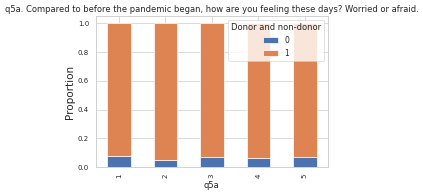

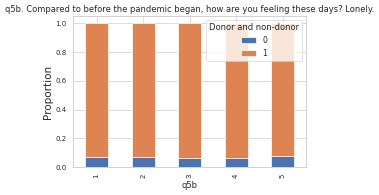

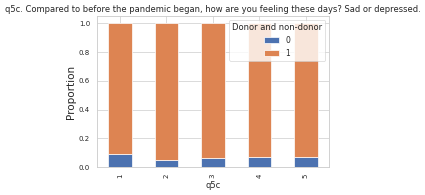

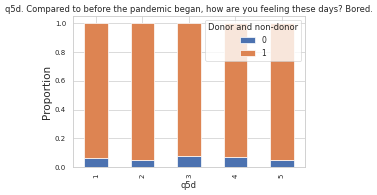

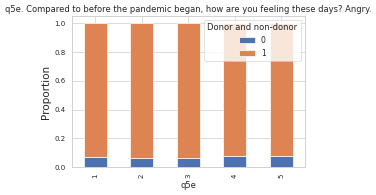

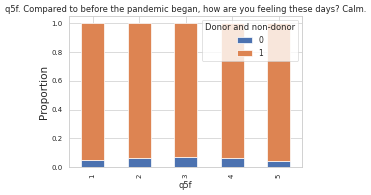

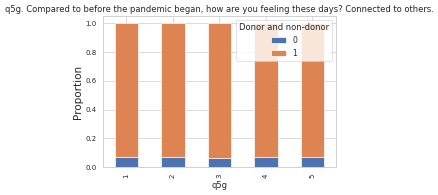

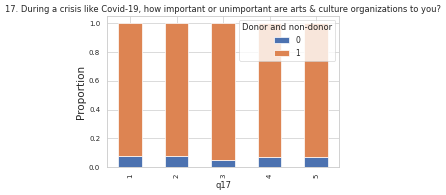

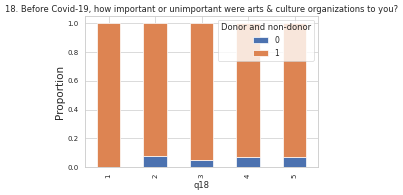

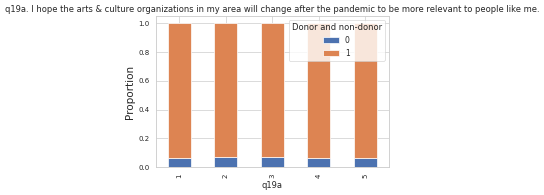

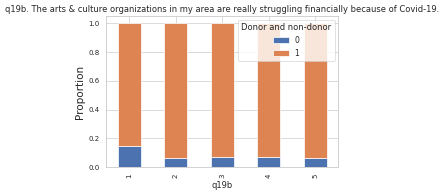

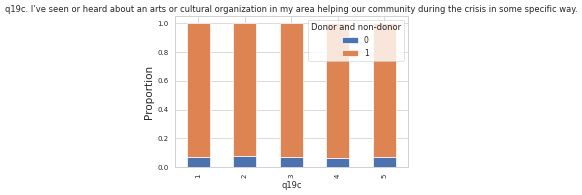

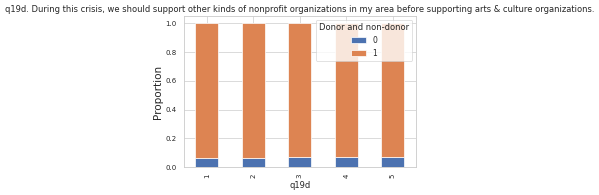

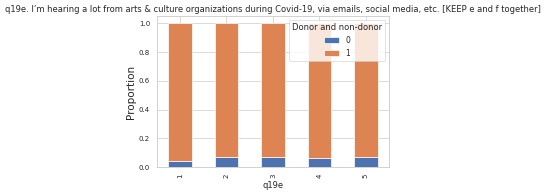

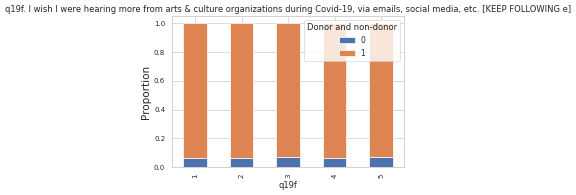

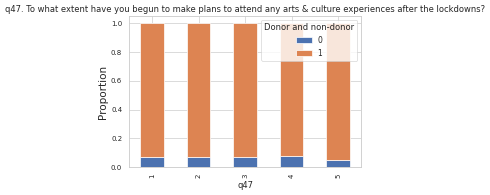

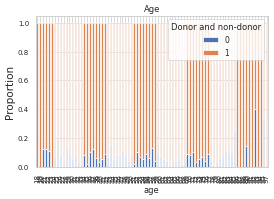

In [ ]:
# donors to non-donors
# each value adds up to 100%

for numvar in full_num_vars: 
  ct = pd.crosstab(df2[numvar], df2['q21']).apply(lambda r: round((r/r.sum()),2), axis=1) # crosstab

  # plotting stacked bar graphs
  plt.rcParams['figure.dpi'] = 50
  sns.set(style="whitegrid") 
  ct.plot.bar(stacked=True)
  plt.title(varsWnolabels[numvar]) # using dictionary to add labels, to each graph title, for to each variable
  plt.legend(title='Donor and non-donor')
  plt.ylabel('Proportion', size=15)

  plt.xticks(size=10)
  plt.yticks(size=10)
  plt.show()
  print('\n')


**diving into a trend that stands out -looks promising**

<Figure size 3750x2500 with 0 Axes>

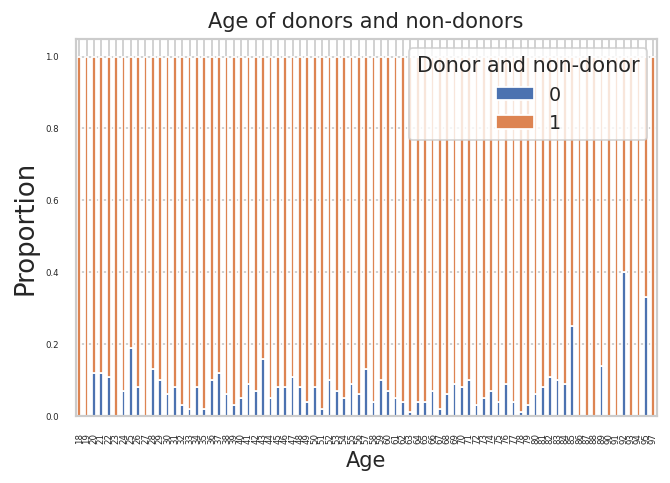

In [ ]:
ct = pd.crosstab(df2['age'], df2['q21']).apply(lambda r: round((r/r.sum()),2), axis=1) # crosstab
plt.figure(figsize=(30, 20))
# plotting stacked bar graphs
plt.rcParams['figure.dpi'] = 125 
sns.set(style="whitegrid") 
ct.plot.bar(stacked=True)

plt.title('Age of donors and non-donors') # using dic to add actual question as the title
plt.legend(title='Donor and non-donor')
plt.ylabel('Proportion', size=15)
plt.xlabel('Age')

plt.xticks(size=5,)
plt.yticks(size=5)
plt.show()
print('\n')

# each value adds up to 100%

**getting a better graph**

In [ ]:
ndon = list(ct[0])
don = list(ct[1])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_stacked_bar(data, series_labels, category_labels=None, 
                     show_values=False, value_format="{}", y_label=None, x_label=None, title=None,
                     colors=None, grid=True, reverse=False):
    """""Plots a stacked bar chart with the data and labels provided.

    Keyword arguments:
    data            -- 2-dimensional numpy array or nested list
                       containing data for each series in rows
    series_labels   -- list of series labels (these appear in
                       the legend)
    category_labels -- list of category labels (these appear
                       on the x-axis)
    show_values     -- If True then numeric value labels will 
                       be shown on each bar
    value_format    -- Format string for numeric value labels
                       (default is "{}")
    y_label         -- Label for y-axis (str)
    colors          -- List of color labels
    grid            -- If True display grid
    reverse         -- If True reverse the order that the
                       series are displayed (left-to-right
                       or right-to-left)
    """

    ny = len(data[0])
    ind = list(range(ny))

    axes = []
    cum_size = np.zeros(ny)

    data = np.array(data)

    if reverse:
        data = np.flip(data, axis=1)
        category_labels = reversed(category_labels)

    for i, row_data in enumerate(data):
        color = colors[i] if colors is not None else None
        axes.append(plt.bar(ind, row_data, bottom=cum_size, 
                            label=series_labels[i], color=color))
        cum_size += row_data

    if category_labels:
        plt.xticks(ind, category_labels)

    if y_label:
        plt.ylabel(y_label)
    
    if x_label:
        plt.xlabel(x_label)

    if title:
        plt.title(title)

    plt.legend()

    if grid:
        plt.grid()

    if show_values:
        for axis in axes:
            for bar in axis:
                w, h = bar.get_width(), bar.get_height()
                plt.text(bar.get_x() + w/2, bar.get_y() + h/2, 
                         value_format.format(h), ha="center", 
                         va="center")

In [ ]:
ndon = list(ct[0])
don = list(ct[1])
labels = list(ct.index.values) 
labels2 = []
for i in labels:
  if (i % 2) == 0:
    labels2.append(i)
  else:
    labels2.append('')

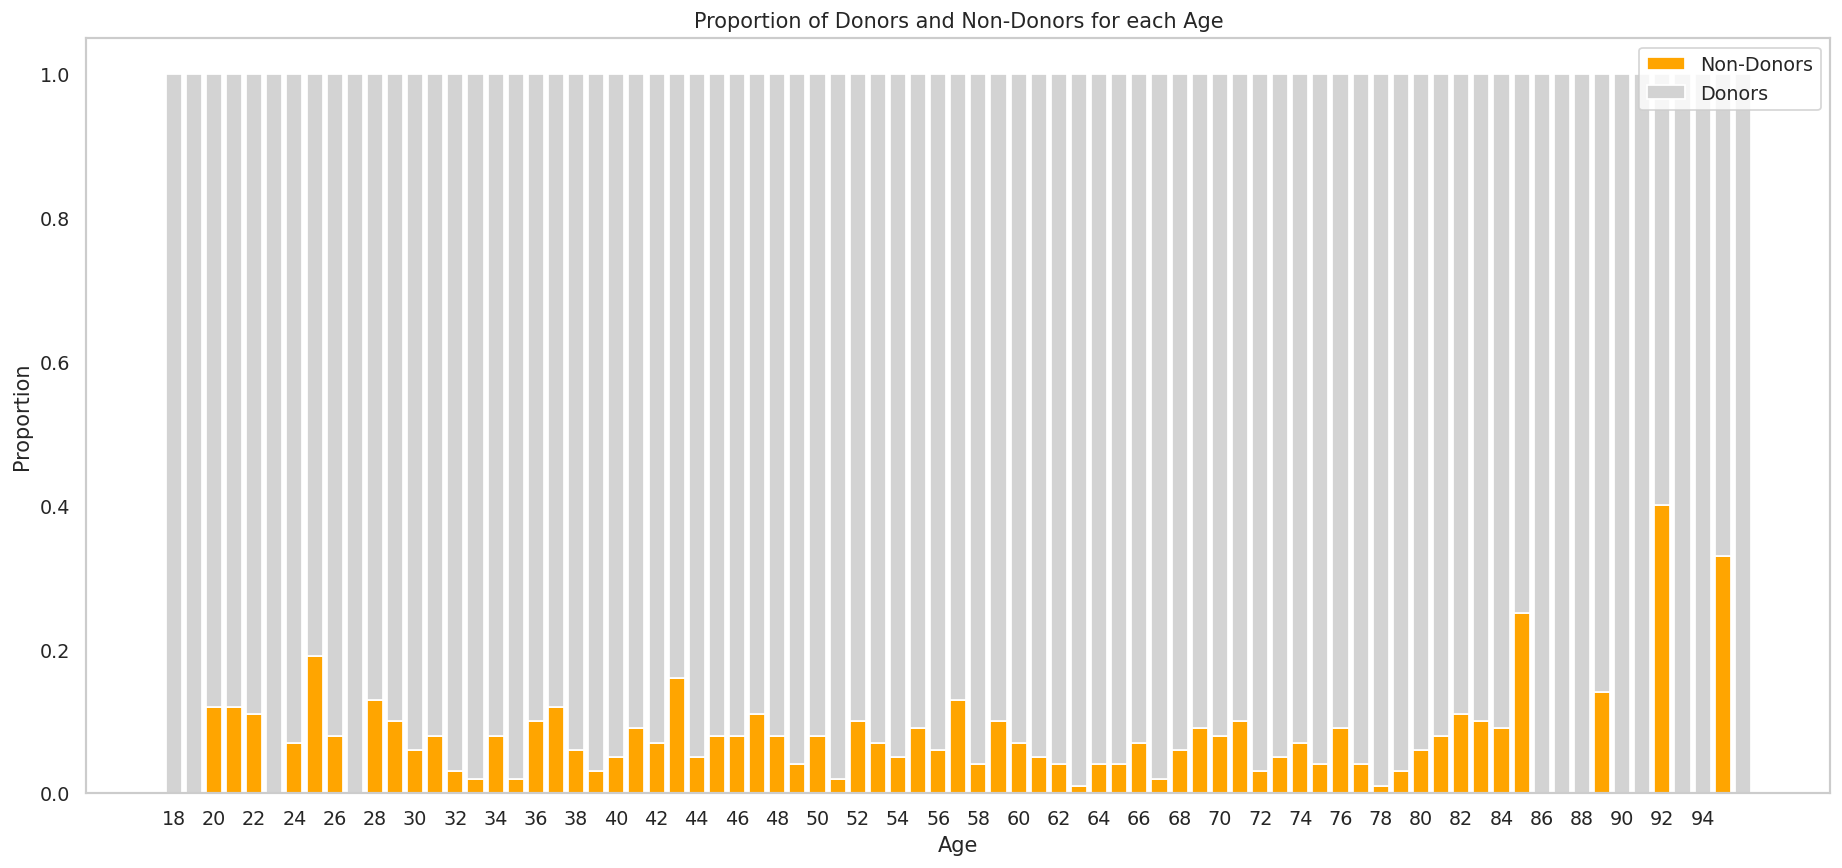

In [ ]:
plt.figure(figsize=(18, 8))

series_labels = ['Non-Donors','Donors']

data = [
    ndon,
    don
]

category_labels = labels2

plot_stacked_bar(
    data, 
    series_labels, 
    category_labels=category_labels, 
    show_values=False, 
    value_format="{:.1f}",
    colors=["orange", 'lightgrey'],
    y_label="Proportion",
    x_label="Age",
    title='Proportion of Donors and Non-Donors for each Age'
)

plt.savefig('bar.png')
plt.show()

## Correlation matrix

**analyzing questions were survey takers could only select one option**

In [ ]:
vars = list(df2.columns)
# all desired vars start w/ the following from the list
quest = ['q21','q5','q17','q18','q19','q47','Agecat','q40','q41','q42','REGION9','age'] 


# creating a list of all one anwers questions
one_ans_scale_qs = []
for var in quest:
  for full_var in vars:
    if var in full_var:
      one_ans_scale_qs.append(full_var)

one_ansQs_df = df2[one_ans_scale_qs]

In [ ]:
corr = one_ansQs_df.corr()
corr_pairs = corr.unstack()
sorted_pairs = corr_pairs.sort_values(kind="quicksort")
negative_pairs = sorted_pairs[sorted_pairs < -0.5]
strong_pairs = sorted_pairs[abs(sorted_pairs) > 0.30].drop_duplicates()
print('Strongest correlation pairs above absolute 0.30')
print('---------------------------------------------------','\n')
print(strong_pairs)

Strongest correlation pairs above absolute 0.30
--------------------------------------------------- 

q41_Working – as a paid employee      q41_Not working – retired              -0.576696
Agecat_65+                            Agecat_50-64                           -0.522964
q40_Master’s degree                   q40_Bachelor’s degree                  -0.518781
Agecat_35-49                          Agecat_65+                             -0.405144
q40_Master’s degree                   q40_Professional or doctorate degree   -0.333555
q40_Professional or doctorate degree  q40_Bachelor’s degree                  -0.323360
q42_Prefer not to answer              q42_$50,000–$99,999                    -0.312954
q21                                   q21                                     1.000000
dtype: float64


correlation heatmap 



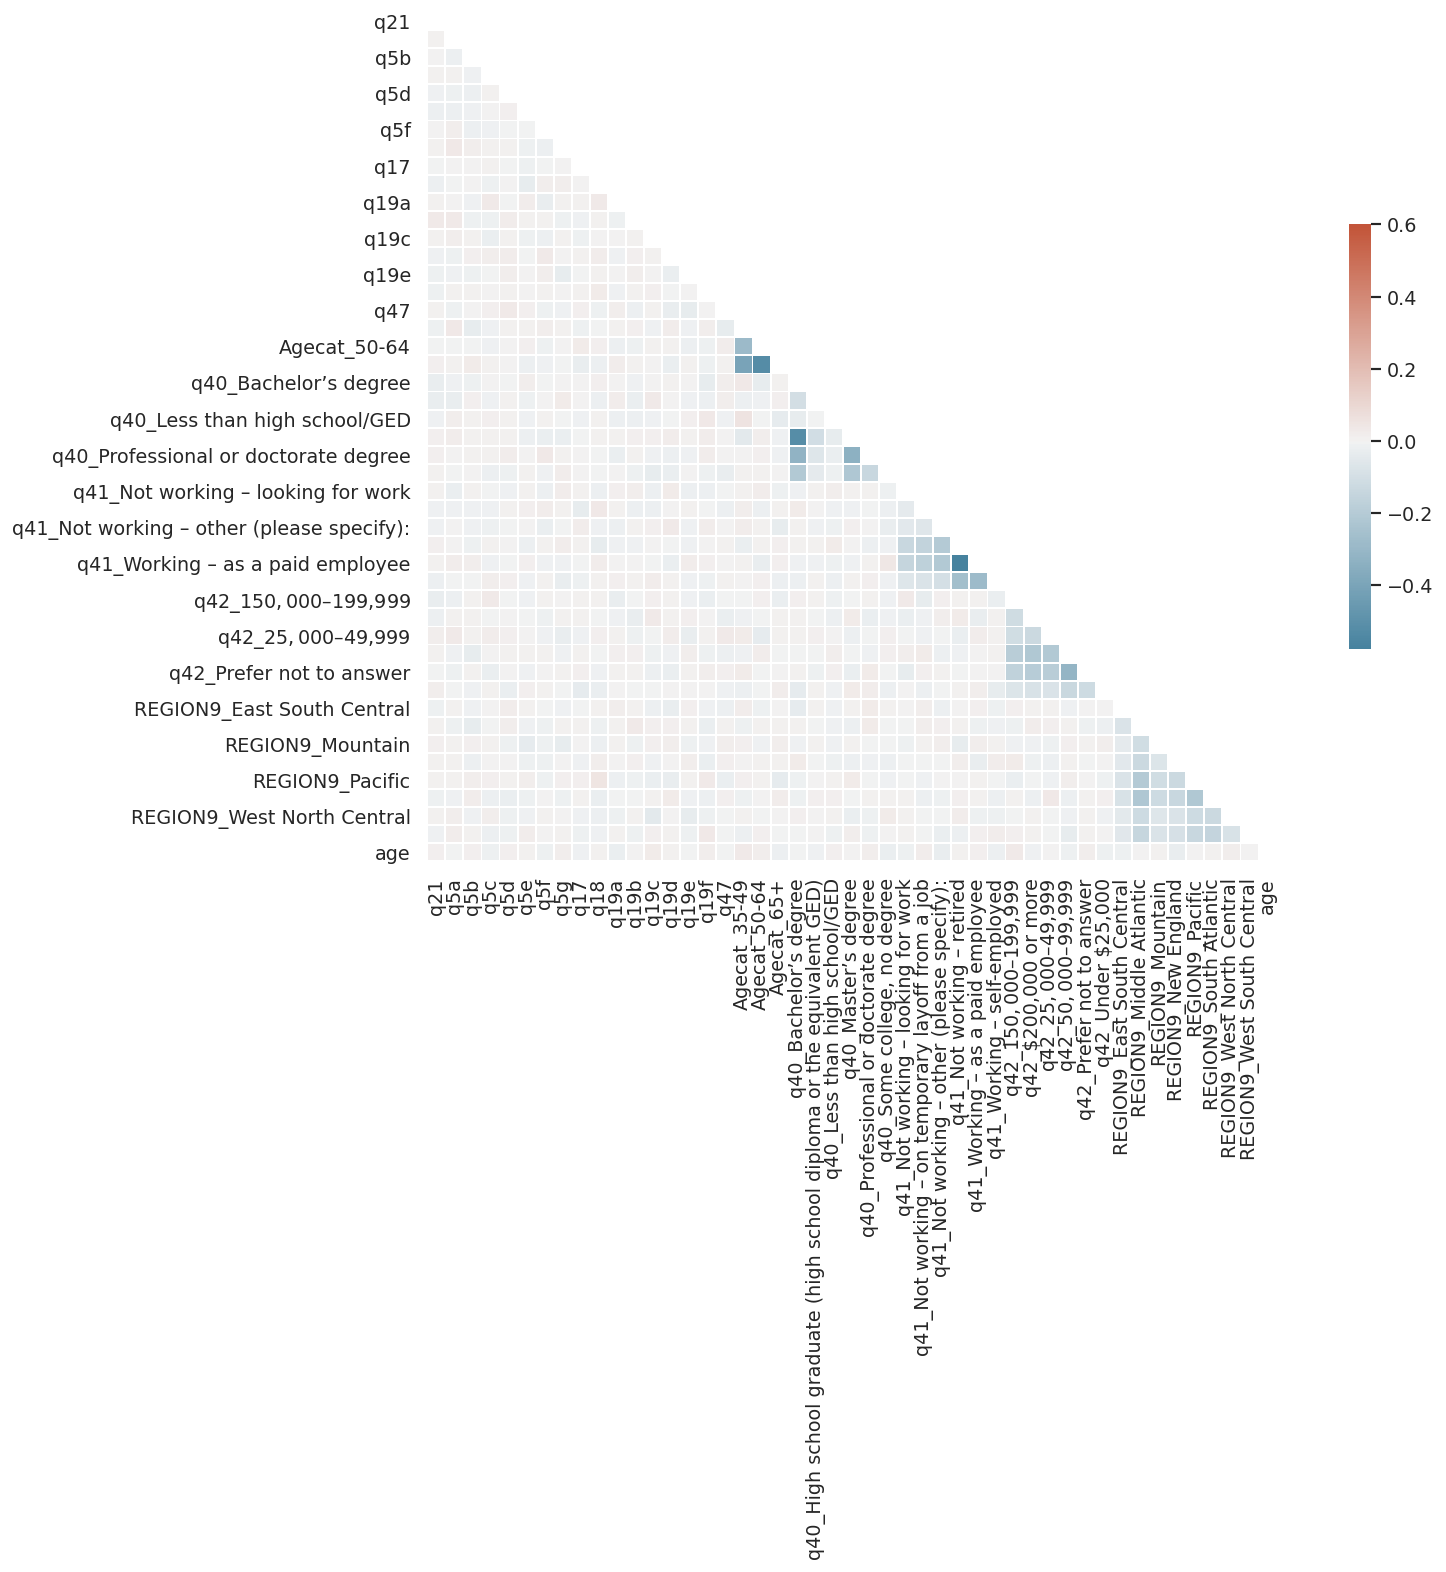

In [ ]:
sns.set_theme(style="white")
# correlation matrix
corr = one_ansQs_df.corr()
# mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# matplotlib figure
f, ax = plt.subplots(figsize=(15, 9))
# custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# heatmap with the mask and correct aspect ratio
print('correlation heatmap','\n')
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.6, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Histograms

for questions where survey takers could only select one choice

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f558b05a550>,
      dtype=object)

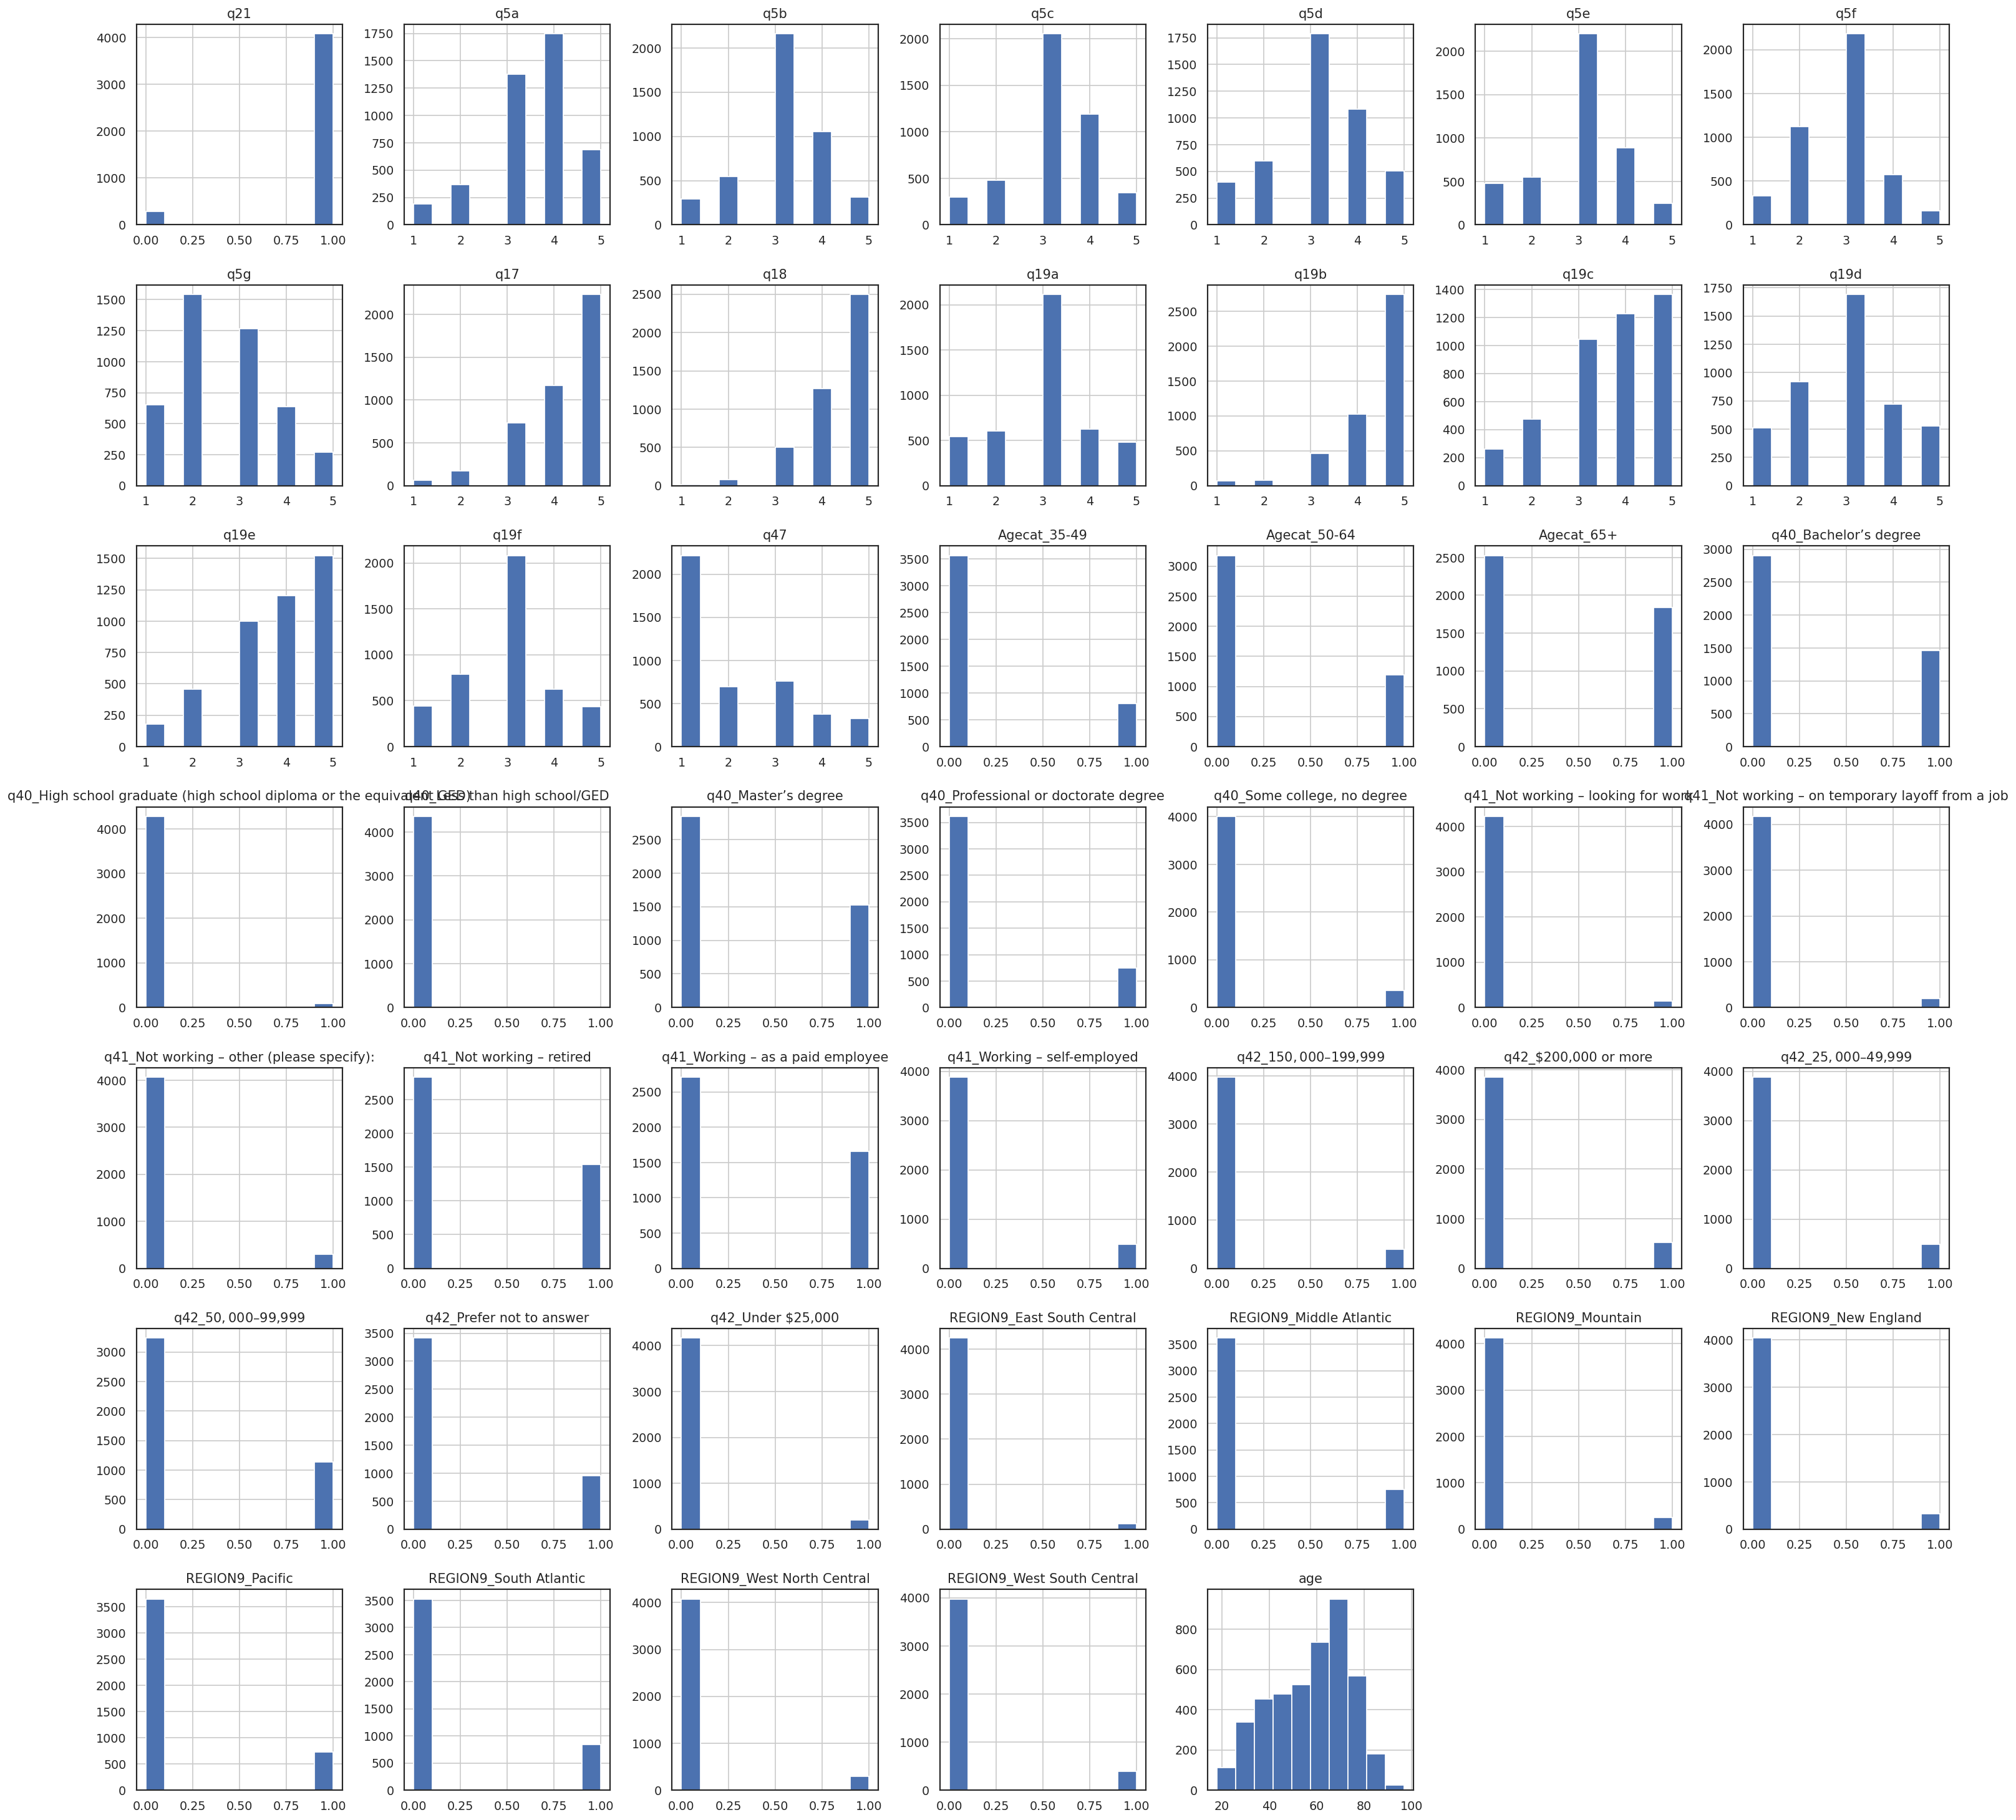

In [ ]:
one_ansQs_df.hist(figsize=(30, 30))

## Ranking options for Multi-Select Choice Questions (MSCQ)

**The following functions(collectively) works as follows:**

1. grouping all variables belonging to the same question (e.g., q1_1, q1_b,q1_c...belong to the same question)

2. obtain their labels from the dictionary I created

3. calculate percentages per checked option to the total, and grouping by donors and non-donors

4. plot them

In [ ]:
# gets all the columns that belongs to a question
def all_dumms_in_question(df2, target_var):
  vars = list(df2.columns)
  target_lst = []
  for var in vars:
    if target_var in var:
      target_lst .append(var)
  return target_lst

# gets all labels to that question by using the dictionary created ealier
# specifically the positive labels
def dummy_pos_vals(quests):
  pos_vals = []
  for dummy in quests:
    for key in mydict:
      if dummy == key:
        for i in list(mydict[dummy]):
          if "NO TO:" not in i:
            pos_vals.append(i)
  return pos_vals 

In [ ]:
# returns the proportion of donors and non-donors that checked each question option
# off an option as a proportion to the total number of checked option from that question

def donorNondonor_percents_per_q(part_quest, df2):
  # all dummy vars
  quests = all_dumms_in_question(df2, part_quest)

  #getting sum of each dummy var
  sum_donor_lst = []
  sum_NONdonor_lst = []
  var_list = []
  for var in quests:
    var_list.append(var)
    sum_donor = df2[ (df2[var] == 1) &  (df2['q21'] == 1)][var].sum() # want checked options from donors
    sum_NONdonor = df2[ (df2[var] == 1) &  (df2['q21'] == 0)][var].sum() # want checked options from non-donors
    sum_donor_lst.append(sum_donor)
    sum_NONdonor_lst.append(sum_NONdonor)

  #sum_total = sum_donor_lst + sum_NONdonor_lst
  perc_donor_lst = []
  perc_NONdonor_lst = []
  total = sum(sum_NONdonor_lst) + sum(sum_donor_lst)

  for num in sum_donor_lst:
    perc = round(num/total,2)
    perc_donor_lst.append(perc)

  for num in sum_NONdonor_lst:
    perc = round(num/total,2)
    perc_NONdonor_lst.append(perc)

  # getting positive values for each dummy var
  labels = dummy_pos_vals(quests)    #if there is no positive dummy var then an error will occur

  return perc_donor_lst, perc_NONdonor_lst, labels, part_quest

In [ ]:
# plots the data

def plot_dono_Nondono(perc_donor_lst, perc_NONdonor_lst, labels, part_quest, act_quest):
  #plotting side bar graph
  objects = labels
  y_pos = np.arange(len(objects))
  performance = perc_NONdonor_lst
  performance2 = perc_donor_lst


  plt.barh(y_pos, performance, align='edge', alpha=1, label='Non-Donors',color='navy')
  plt.barh(y_pos, performance2, align='edge', alpha=0.5,label='Donors',color='mediumseagreen')
  plt.yticks(y_pos, objects)
  plt.xlabel('Proportion of total checked options')
  plt.title('{}. {}'.format(part_quest, act_quest))
  plt.legend(loc='best')
  plt.figure(figsize=(10,5), frameon=True)
  plt.show()

double cheking the code

In [ ]:
# double checking the code
# print(df2.groupby('q21')['q7_1'].value_counts())
quests = all_dumms_in_question(df2, 'q7_')

#getting sum of each dummy var
sum_donor_lst = []
sum_NONdonor_lst = []
var_list = []
for var in quests:
  var_list.append(var)
  sum_donor = df2[ (df2[var] == 1) &  (df2['q21'] == 1)][var].sum() # want checked options from donors
  sum_NONdonor = df2[ (df2[var] == 1) &  (df2['q21'] == 0)][var].sum() # want checked options from non-donors
  sum_donor_lst.append(sum_donor)
  sum_NONdonor_lst.append(sum_NONdonor)

#sum_total = sum_donor_lst + sum_NONdonor_lst
perc_donor_lst = []
perc_NONdonor_lst = []
total = sum(sum_NONdonor_lst) + sum(sum_donor_lst)

for num in sum_donor_lst:
  perc = round(num/total,2)
  perc_donor_lst.append(perc)

for num in sum_NONdonor_lst:
  perc = round(num/total,2)
  perc_NONdonor_lst.append(perc)

n = sum(sum_NONdonor_lst)
print('Total checked options for all vars from non-donors:',n)
d = sum(sum_donor_lst)
print('Total checked options for all vars from donors:',d)
t = n + d
n/t

Total checked options for all vars from non-donors: 3869
Total checked options for all vars from donors: 54908


0.06582506762849413

**Q1**

note: each y-label is a dataframe column

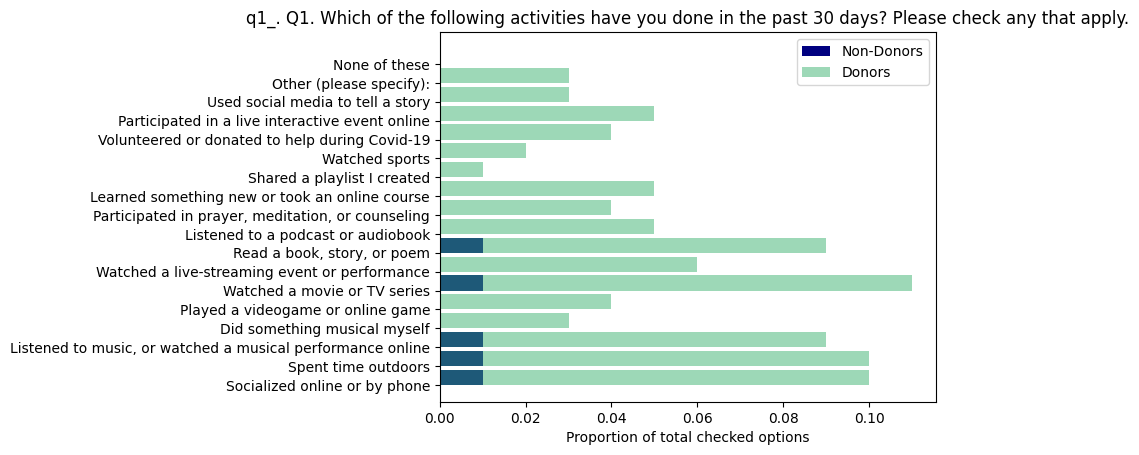

<Figure size 1000x500 with 0 Axes>

Non-donors total checked options: 0.05
Donors total checked options: 0.94


In [ ]:
# if you add all non-donors and donors proportion for each option, you get 1
part_quest = 'q1_'
act_quest = 'Q1. Which of the following activities have you done in the past 30 days? Please check any that apply.'
perc_donor_lst, perc_NONdonor_lst, labels, quest = donorNondonor_percents_per_q(part_quest, df2)
plot_dono_Nondono(perc_donor_lst, perc_NONdonor_lst, labels, part_quest, act_quest)
perc_donor_lst, perc_NONdonor_lst, labels, part_quest = donorNondonor_percents_per_q('q1_', df2)

perc_donor_lst, perc_NONdonor_lst, labels, part_quest = donorNondonor_percents_per_q(part_quest, df2)
print('Non-donors total checked options:', round(sum(perc_NONdonor_lst),2))
print('Donors total checked options:',round(sum(perc_donor_lst),2))

**Q2**

note: each y-label is a dataframe column

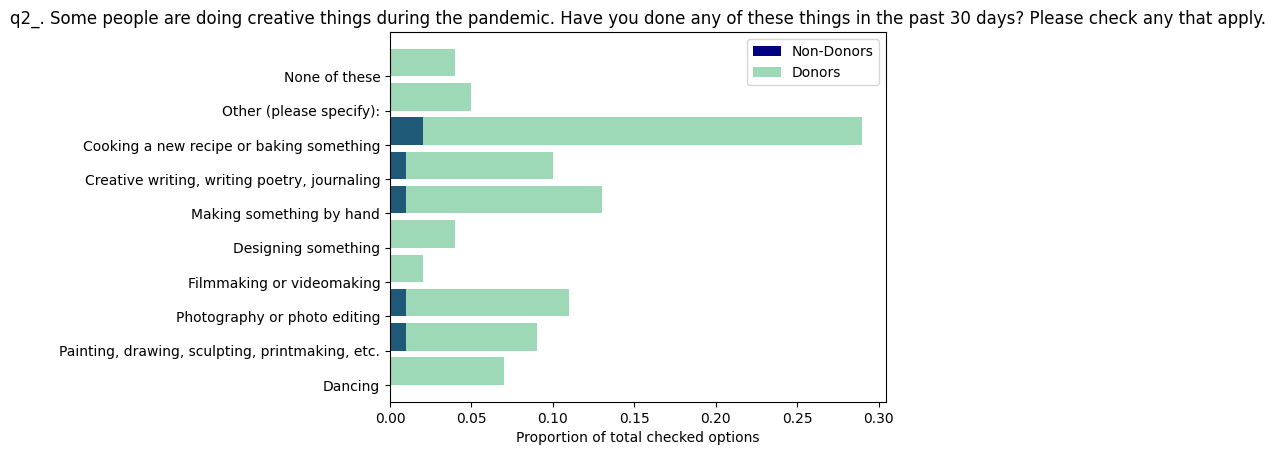

<Figure size 1000x500 with 0 Axes>

Non-donors total checked options: 0.06
Donors total checked options: 0.94


In [ ]:
part_quest = 'q2_'
act_quest = 'Some people are doing creative things during the pandemic. Have you done any of these things in the past 30 days? Please check any that apply.'
perc_donor_lst, perc_NONdonor_lst, labels, quest = donorNondonor_percents_per_q(part_quest, df2)
plot_dono_Nondono(perc_donor_lst, perc_NONdonor_lst, labels, part_quest, act_quest)

perc_donor_lst, perc_NONdonor_lst, labels, part_quest = donorNondonor_percents_per_q(part_quest, df2)
print('Non-donors total checked options:', round(sum(perc_NONdonor_lst),2))
print('Donors total checked options:',round(sum(perc_donor_lst),2))

## Most frequent combinations from MSCQ

looking at number of combinations that exist per survey question and the count per combination

In [ ]:
# returns the count for each of the top 10 selected word combinations 
# from a select all that apply question or select upt to X number of options

def top_quest_combinations(df2, partial_var_of_main_question, mydict, neg_key_val):

  # gets all dummy variables from a dataset
  def all_dumms_in_question(df2, target_var):
    vars = list(df2.columns)
    target_lst = []
    for var in vars:
      if target_var in var:
        target_lst .append(var)
    return target_lst

  # converts a list into tuple
  def convert(list): 
      return tuple(list) 

  # uses a list of dummy variables and dataframe 
  # returns the top 10 combinations in the dataset
  def top_dumm_comb(df2,q_dumms):
    q_df = df2[q_dumms].to_numpy()
    for x in q_df:
      convert(x) 
    c = Counter(tuple(x) for x in q_df)
    return c.most_common(10)

  # gets all dummies for a variable and outputs top 10 combinations
  q1_dumms = all_dumms_in_question(df2, partial_var_of_main_question)
  top = top_dumm_comb(df2,q1_dumms)

  # gives me just the combinations
  def extract_combs(lst): 
      return [item[0] for item in lst], [item[1] for item in lst]

  combs_lst,sum_lst = extract_combs(top)

  # replacing 0's and 1's combinations with dummy variable names
  var_combs = []
  for combination in combs_lst: 
    counter = 0
    var_comb = []
    for dummy in combination:
      if dummy == 1:
        var_comb.append(q1_dumms[counter])
      counter = counter + 1 
    var_combs.append(var_comb)

  #outputs the the key when the value is 1
  def key_pos_val(mydict, dummy_var,neg_key_val):
    rep_0N1 = []
    keys = list(mydict[dummy_var])
    for key in keys:
      if neg_key_val in key: 
        continue
      else:
        rep_0N1.append(key)
      return str(key) 

  # replaces dummy variable names with their positive key values
  lst = []
  for comb_set in var_combs:
    l = []
    for dummy in comb_set:
        l.append(key_pos_val(mydict,dummy,neg_key_val))
    lst.append(l)
  return lst, sum_lst

In [ ]:
a,b = top_quest_combinations(df2, 'q1_',mydict, 'NO TO') 
print("Question 1.{}Top {:>2} combinations: {}".format('\n',len(a), '\n'))
#print("Total number of combinations: {:>2} combinations".format(18**16))
count = 0
for i in a:
  count = count + 1 
  txt = 'Combination {:>2}: {:>4} option/s selected;   Total number of people who selected this combination: {:>5}'.format(str(count),len(i),b[count-1] )
  print(txt)

Question 1.
Top 10 combinations: 

Combination  1:    7 option/s selected;   Total number of people who selected this combination:    24
Combination  2:    6 option/s selected;   Total number of people who selected this combination:    16
Combination  3:    5 option/s selected;   Total number of people who selected this combination:    15
Combination  4:    7 option/s selected;   Total number of people who selected this combination:    14
Combination  5:    6 option/s selected;   Total number of people who selected this combination:    13
Combination  6:    7 option/s selected;   Total number of people who selected this combination:    12
Combination  7:    7 option/s selected;   Total number of people who selected this combination:    11
Combination  8:    7 option/s selected;   Total number of people who selected this combination:    11
Combination  9:    7 option/s selected;   Total number of people who selected this combination:    11
Combination 10:    7 option/s selected;   Total

In [ ]:
a,b = top_quest_combinations(df2, 'q2_',mydict, 'NO TO') 
print("Question 2.{}Top {:>2} combinations: {}".format('\n',len(a), '\n'))
count = 0
for i in a:
  count = count + 1 
  txt = 'Combination {:>2}: {:>4} option/s selected;   Total number of people who selected this combination: {:>5}'.format(str(count),len(i),b[count-1] )
  print(txt)

Question 2.
Top 10 combinations: 

Combination  1:    1 option/s selected;   Total number of people who selected this combination:   531
Combination  2:    2 option/s selected;   Total number of people who selected this combination:   237
Combination  3:    0 option/s selected;   Total number of people who selected this combination:   206
Combination  4:    2 option/s selected;   Total number of people who selected this combination:   182
Combination  5:    2 option/s selected;   Total number of people who selected this combination:   163
Combination  6:    2 option/s selected;   Total number of people who selected this combination:   140
Combination  7:    2 option/s selected;   Total number of people who selected this combination:   101
Combination  8:    1 option/s selected;   Total number of people who selected this combination:    85
Combination  9:    3 option/s selected;   Total number of people who selected this combination:    79
Combination 10:    3 option/s selected;   Total

# Models

In [ ]:
from sklearn.metrics import confusion_matrix, f1_score, recall_score, classification_report
from sklearn.metrics import f1_score, recall_score, accuracy_score, balanced_accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
import random

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


**last preprocessing steps**

dummy coding geographical variables

In [ ]:
# dymmy coding last geographical variables
non_dumvars = ['CityName','CountyName','StateName'] 
df3 = pd.get_dummies(df2, columns=non_dumvars, drop_first=True) 
print('Dataset shape: ', df3.shape)

Dataset shape:  (4369, 6559)


**to speed up modeling, I use a fraction of the dataset**

In [ ]:
# to speed up the modeling
df3 = df3.sample(frac=0.99) 
print('Sample dataset shape: ', df3.shape)

Sample dataset shape:  (4325, 6559)


**splitting into train and test sets**

In [ ]:
# getting sample weight for training and testing sets too
Xdf = df3.drop(['q21','weightALL'], axis=1) # to get column names for training set


X = df3.drop(['q21'], axis=1) # ind vars w/ weighted var
y = df3['q21'].values # target var
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 6) # datasets are in dataframe format


# obtaining the weight sample variable for X_train & X_test
weightALL_X_train = X_train['weightALL'].values # need the sample weights after splitting datasets
X_train = X_train.drop(['weightALL'], axis=1).values # dropping sample weights var and getting np.array
weightALL_X_test = X_test['weightALL'].values # need the sample weights after splitting datasets
X_test = X_test.drop(['weightALL'], axis=1).values 

In [ ]:
print('Count of donors and non-donors')
print(df3['q21'].value_counts())

Count of donors and non-donors
1    4028
0     278
Name: q21, dtype: int64


## Scaling train/test dataset

**Z-score scaling**

In [ ]:
z_sc = StandardScaler()
X_train_z = z_sc.fit_transform(X_train)
X_test_z = z_sc.transform(X_test)

**min-max scaling**

In [ ]:
minmax_sc = MinMaxScaler()
X_train_minmax = minmax_sc.fit_transform(X_train)
X_test_minmax = minmax_sc.transform(X_test)

## Non-tuned models

creating non-tuned models first to get a baseline

In [ ]:
s = '-------------------------------------------------------------------------'
l = '\n'
x = 'xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx'

**Models with default hyper-parameters are produced to get a baseline.**

In [ ]:
# function creates a classifier and outputs 
# a confusion matrix & classification report 
# for unscaled data, z-scaled, and min-max scaled
# with and w/o sample weight variable


def classifier_model(model, X_train, X_test, y_train, y_test):
  try:
    classifier = model
    classifier.fit(X_train, y_train, sample_weight = weightALL_X_train)
    y_pred = classifier.predict(X_test)
    target_names = ['Non-donors', 'Donors']
    
    # classifier w/ sample weight entered
    print(l,'Weighted sample applied:',l,x)
    print(l,confusion_matrix(y_test, y_pred,sample_weight = weightALL_X_test))
    print(l,classification_report(y_test, y_pred, target_names=target_names, sample_weight = weightALL_X_test))
    
    # classifier w/ no sample weight entered
    print(l,'No weight sample applied:',l,x)
    print(l,confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred, target_names=target_names))
  except:
    # for classifiers that do not have a sample weight input option
    y_pred = classifier.predict(X_test)
    target_names = ['Non-donors', 'Donors']
    print(l,'No weight sample applied:',l,x)
    print(l,confusion_matrix(y_test, y_pred))
    print(l,classification_report(y_test, y_pred, target_names=target_names))

### XGBoost (eXtreme Gradient Boosting)

In [ ]:
import xgboost as xgb
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sn

In [ ]:
model = XGBClassifier()
model.fit(X_train, y_train, sample_weight = weightALL_X_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, sample_weight = weightALL_X_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00 64.22744764763611
           1       0.95      1.00      0.98 1336.6446097971316

    accuracy                           0.95 1400.8720574447677
   macro avg       0.48      0.50      0.49 1400.8720574447677
weighted avg       0.91      0.95      0.93 1400.8720574447677



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Random forest**

In [ ]:
print(s, l, "Non-scaled x-train/test dataset")
classifier_model(RandomForestClassifier(), X_train, X_test, y_train, y_test)
print(s, l, "Z_score-scaled x-train/test dataset")
classifier_model(RandomForestClassifier(), X_train_z, X_test_z, y_train, y_test)
print(s, l, "Min_max-scaled x-train/test dataset")
classifier_model(RandomForestClassifier(), X_train_minmax, X_test_minmax, y_train, y_test)

------------------------------------------------------------------------- 
 Non-scaled x-train/test dataset

 Weighted sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[   0.           64.22744765]
 [   0.         1336.6446098 ]]

               precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00 64.22744764763611
      Donors       0.95      1.00      0.98 1336.6446097971316

    accuracy                           0.95 1400.8720574447677
   macro avg       0.48      0.50      0.49 1400.8720574447677
weighted avg       0.91      0.95      0.93 1400.8720574447677


 No weight sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[   0   75]
 [   0 1002]]
              precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00        75
      Donors       0.93      1.00      0.96      1002

    accuracy                           0.93      1077
   macro avg       0.47      0.50      0.48      1077


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Weighted sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[   0.           64.22744765]
 [   0.         1336.6446098 ]]

               precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00 64.22744764763611
      Donors       0.95      1.00      0.98 1336.6446097971316

    accuracy                           0.95 1400.8720574447677
   macro avg       0.48      0.50      0.49 1400.8720574447677
weighted avg       0.91      0.95      0.93 1400.8720574447677


 No weight sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[   0   75]
 [   0 1002]]
              precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00        75
      Donors       0.93      1.00      0.96      1002

    accuracy                           0.93      1077
   macro avg       0.47      0.50      0.48      1077
weighted avg       0.87      0.93      0.90      1077

-----------------------------------------------------

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



 Weighted sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[   0.           64.22744765]
 [   0.         1336.6446098 ]]

               precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00 64.22744764763611
      Donors       0.95      1.00      0.98 1336.6446097971316

    accuracy                           0.95 1400.8720574447677
   macro avg       0.48      0.50      0.49 1400.8720574447677
weighted avg       0.91      0.95      0.93 1400.8720574447677


 No weight sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[   0   75]
 [   0 1002]]
              precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00        75
      Donors       0.93      1.00      0.96      1002

    accuracy                           0.93      1077
   macro avg       0.47      0.50      0.48      1077
weighted avg       0.87      0.93      0.90      1077



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Gradient Boosting**

In [ ]:
print(s, l, "Non-scaled x-train/test dataset")
classifier_model(GradientBoostingClassifier(), X_train, X_test, y_train, y_test)
print(s, l, "Z_score-scaled x-train/test dataset")
classifier_model(GradientBoostingClassifier(), X_train_z, X_test_z, y_train, y_test)
print(s, l, "Min_max-scaled x-train/test dataset")
classifier_model(GradientBoostingClassifier(), X_train_minmax, X_test_minmax, y_train, y_test)

------------------------------------------------------------------------- 
 Non-scaled x-train/test dataset

 Weighted sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[0.00000000e+00 6.42274476e+01]
 [4.66622094e-01 1.33617799e+03]]

               precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00 64.22744764763611
      Donors       0.95      1.00      0.98 1336.6446097971316

    accuracy                           0.95 1400.8720574447677
   macro avg       0.48      0.50      0.49 1400.8720574447677
weighted avg       0.91      0.95      0.93 1400.8720574447677


 No weight sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[  0  75]
 [  6 996]]
              precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00        75
      Donors       0.93      0.99      0.96      1002

    accuracy                           0.92      1077
   macro avg       0.46      0.50      0.48      1077


### **Logistic regression**

In [ ]:
print(s, l, "Non-scaled x-train/test dataset")
classifier_model(LogisticRegression(max_iter=10000), X_train, X_test, y_train, y_test)
print(s, l, "Z_score-scaled x-train/test dataset")
classifier_model(LogisticRegression(max_iter=10000), X_train_z, X_test_z, y_train, y_test)
print(s, l, "Min_max-scaled x-train/test dataset")
classifier_model(LogisticRegression(max_iter=10000), X_train_minmax, X_test_minmax, y_train, y_test)

------------------------------------------------------------------------- 
 Non-scaled x-train/test dataset

 Weighted sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[8.27111503e-01 6.34003361e+01]
 [1.20687031e+02 1.21595758e+03]]

               precision    recall  f1-score   support

  Non-donors       0.01      0.01      0.01 64.22744764763611
      Donors       0.95      0.91      0.93 1336.6446097971316

    accuracy                           0.87 1400.8720574447677
   macro avg       0.48      0.46      0.47 1400.8720574447677
weighted avg       0.91      0.87      0.89 1400.8720574447677


 No weight sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[  2  73]
 [ 33 969]]
              precision    recall  f1-score   support

  Non-donors       0.06      0.03      0.04        75
      Donors       0.93      0.97      0.95      1002

    accuracy                           0.90      1077
   macro avg       0.49      0.50      0.49      1077


### **Naive Bayes**

In [ ]:
print(s, l, "Non-scaled x-train dataset")
classifier_model(GaussianNB(), X_train, X_test, y_train, y_test)
print(s, l, "Z_score-scaled x-train dataset")
classifier_model(GaussianNB(), X_train_z, X_test_z, y_train, y_test)
print(s, l, "Min_max-scaled x-train dataset")
classifier_model(GaussianNB(), X_train_minmax, X_test_minmax, y_train, y_test)

------------------------------------------------------------------------- 
 Non-scaled x-train dataset

 Weighted sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[  25.73939722   38.48805043]
 [ 231.07850536 1105.56610444]]

               precision    recall  f1-score   support

  Non-donors       0.10      0.40      0.16 64.22744764763611
      Donors       0.97      0.83      0.89 1336.6446097971316

    accuracy                           0.81 1400.8720574447677
   macro avg       0.53      0.61      0.53 1400.8720574447677
weighted avg       0.93      0.81      0.86 1400.8720574447677


 No weight sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[ 16  59]
 [235 767]]
              precision    recall  f1-score   support

  Non-donors       0.06      0.21      0.10        75
      Donors       0.93      0.77      0.84      1002

    accuracy                           0.73      1077
   macro avg       0.50      0.49      0.47      1077
weighted 

### **Decision tree**

In [ ]:
print(s, l, "Non-scaled x-train dataset")
classifier_model(DecisionTreeClassifier(), X_train, X_test, y_train, y_test)
print(s, l, "Z_score-scaled x-train dataset")
classifier_model(DecisionTreeClassifier(), X_train_z, X_test_z, y_train, y_test)
print(s, l, "Min_max-scaled x-train dataset")
classifier_model(DecisionTreeClassifier(), X_train_minmax, X_test_minmax, y_train, y_test)

------------------------------------------------------------------------- 
 Non-scaled x-train dataset

 Weighted sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[4.70165602e-01 6.37572820e+01]
 [8.89693198e+01 1.24767529e+03]]

               precision    recall  f1-score   support

  Non-donors       0.01      0.01      0.01 64.22744764763611
      Donors       0.95      0.93      0.94 1336.6446097971316

    accuracy                           0.89 1400.8720574447677
   macro avg       0.48      0.47      0.47 1400.8720574447677
weighted avg       0.91      0.89      0.90 1400.8720574447677


 No weight sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[  2  73]
 [ 47 955]]
              precision    recall  f1-score   support

  Non-donors       0.04      0.03      0.03        75
      Donors       0.93      0.95      0.94      1002

    accuracy                           0.89      1077
   macro avg       0.48      0.49      0.49      1077
weigh

In [ ]:
#files.download('models_summary.csv')

### Best non-tuned models

In [ ]:
#   ONLY APPLICABLE TO ORIGINAL DATASET 

## Under/Over-sampling

Tried this method when I was not using the sample weight. Did not get better performing models compared to the non-tuned counter-part models

In [ ]:
#ns = NearMiss(0.8) 
#X_train_minmax_us, y_train_minmax_us = ns.fit_sample(X_train_minmax, y_train)
#print('The number of class before the fit {}'.format(Counter(y_train)))
#print('The number of class before the fit {}'.format(Counter(y_train_minmax_us)))

#os = RandomOverSampler(0.75) 
#X_train_minmax_os, y_train_minmax_os = os.fit_sample(X_train_minmax, y_train)
#print('The number of class before the fit {}'.format(Counter(y_train)))
#print('The number of class before the fit {}'.format(Counter(y_train_minmax_os))) 

## Tuned models

**Tried to find better models by using different random datasamples for each model. At this stage, I am not using the entire dataset.**

### <font color=”blue”> Random search </font>



**creating an excel file to log model performance over the long run**

In [ ]:
# creating an Excel file
with open('tuned_models_summary.csv', 'w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    csv_writer.writerow(['model','model_best_params','f1_macro','rec_macro','bal_accuracy' ])

# exporting model performance summary into the Excel file
def into_excel(model,model_best_params,f1_macro,rec_macro,bal_accuracy):
  with open('tuned_models_summary.csv', 'a+') as csv_file: # by using 'with open', I do not have to close the file
    first_line = [model,model_best_params,f1_macro,rec_macro,bal_accuracy ]
    csv_writer = csv.writer(csv_file, delimiter=',')
    csv_writer.writerow(first_line)

In [ ]:
# function that produces models with random search
# models are tuned for better f1_macro score
# prints confusion matrix, classification report, and logs performance into excel

def random_para_model(model, X_train, X_test, y_train, random_grid ):
  seed(123)
  # training and fitting the model
  classifier = model()
  classifier_random = RandomizedSearchCV(estimator = classifier, 
                               param_distributions = random_grid, 
                               n_iter = 3, cv = None, random_state=123, 
                               n_jobs = -1, scoring='f1_macro') 
  

  #*************************************************************************************************
  # n_iter are changed according to how much time I have at each coding session ---10 iterations is the norm
  # Number of parameter settings
  #*************************************************************************************************



  # target classes are not balanced so performance metric is based on f1-macro score. Both classes are important.
  classifier_random.fit(X_train, y_train, sample_weight = weightALL_X_train) 
  y_pred = classifier_random.predict(X_test)
  target_names = ['Non-donors', 'Donors']
  print(confusion_matrix(y_test, y_pred, sample_weight = weightALL_X_test))
  print(classification_report(y_test, y_pred, target_names=target_names, sample_weight = weightALL_X_test))

  # logging metrics into excel file
  print(classifier_random.best_params_)
  model_best_params = classifier_random.best_params_
  f1_macro = f1_score(y_test, y_pred, average='macro', sample_weight = weightALL_X_test)
  rec_macro = recall_score(y_test, y_pred, average='macro', sample_weight = weightALL_X_test)
  bal_accuracy = balanced_accuracy_score(y_test, y_pred, sample_weight = weightALL_X_test)
  into_excel(model,model_best_params, round(f1_macro,2), round(rec_macro,2), round(bal_accuracy,2))
  print('f1-macro:',round(f1_macro,2),'rec-macro:',round(rec_macro,2),'bal_accuracy:',round(bal_accuracy,2))

##### <font color=”brown”> Gradient Boosting </font>

In [ ]:
# hyper-parameters I am tuning

loss = ['deviance', 'exponential']
learning_rate = [0.1, 0.3, 0.6, 1, 3]
n_estimators = [100, 200, 300, 500, 750, 1000]
subsample = [0.25, 0.5, 1, 2]
criterion = ['friedman_mse', 'mse', 'mae']
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 5, 20]
max_depth = [3, 6, 10]
max_features = ['auto', 'sqrt', 'log2']
random_grid = dict(loss=loss,learning_rate=learning_rate,n_estimators=n_estimators,
                  subsample=subsample,criterion=criterion,min_samples_split=min_samples_split,
                   min_samples_leaf=min_samples_leaf,max_depth=max_depth,
                   max_features=max_features) 
print('hyper-parameters I am tuning')
print('------------------------------------','\n') 
print(random_grid) 

hyper-parameters I am tuning
------------------------------------ 

{'loss': ['deviance', 'exponential'], 'learning_rate': [0.1, 0.3, 0.6, 1, 3], 'n_estimators': [100, 200, 300, 500, 750, 1000], 'subsample': [0.25, 0.5, 1, 2], 'criterion': ['friedman_mse', 'mse', 'mae'], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 5, 20], 'max_depth': [3, 6, 10], 'max_features': ['auto', 'sqrt', 'log2']}


In [ ]:
#*************************************************************************************************************
# number of loop iterations for each model are changed according to how much time I have at each coding session 
#*************************************************************************************************************

for i in range(1):
  print(s, l, "Min_max-scaled x-train/test dataset")
  
  random_para_model(GradientBoostingClassifier, X_train_minmax, X_test_minmax, y_train, random_grid)
  print(s, l, "Z_score-scaled x-train/test dataset")
  random_para_model(GradientBoostingClassifier, X_train_z, X_test_z, y_train, random_grid)
#files.download('tuned_models_summary.csv')

------------------------------------------------------------------------- 
 Min_max-scaled x-train/test dataset
[[   4.05363371   60.17381394]
 [   1.45195239 1335.1926574 ]]
              precision    recall  f1-score   support

  Non-donors       0.74      0.06      0.12 64.22744764763611
      Donors       0.96      1.00      0.98 1336.6446097971316

    accuracy                           0.96 1400.8720574447677
   macro avg       0.85      0.53      0.55 1400.8720574447677
weighted avg       0.95      0.96      0.94 1400.8720574447677

{'subsample': 1, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 20, 'max_features': 'auto', 'max_depth': 6, 'loss': 'deviance', 'learning_rate': 0.6, 'criterion': 'mse'}
f1-macro: 0.55 rec-macro: 0.53 bal_accuracy: 0.53
------------------------------------------------------------------------- 
 Z_score-scaled x-train/test dataset
[[   4.05363371   60.17381394]
 [   1.45195239 1335.1926574 ]]
              precision    recall  f1-sc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##### <font color=”brown”> Random forest </font>


In [ ]:
# hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 4000, num = 10)] # Number of trees in random forest
max_features = ['auto', 'sqrt', 'log2'] # Number of features to consider at every split
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] # Maximum number of levels in tree
max_depth.append(None)
min_samples_split = [2, 10, 30, 50] 
min_samples_leaf = [2, 10, 15, 50]
class_weight = [ dict({0:16, 1:1}), dict({0:50, 1:1}), dict({0:1, 1:1}) ] # accounting for imbalanced classes
ccp_alpha = [0, 0.5, 1, 5, 10, 20]
bootstrap = [True]
# random grid
random_grid = dict(n_estimators=n_estimators, max_features=max_features, max_depth=max_depth,
                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                   class_weight=class_weight, ccp_alpha=ccp_alpha, bootstrap=bootstrap)
print('hyper-parameters I am tuning')
print('------------------------------------','\n') 
print(random_grid)

hyper-parameters I am tuning
------------------------------------ 

{'n_estimators': [200, 622, 1044, 1466, 1888, 2311, 2733, 3155, 3577, 4000], 'max_features': ['auto', 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 10, 30, 50], 'min_samples_leaf': [2, 10, 15, 50], 'class_weight': [{0: 16, 1: 1}, {0: 50, 1: 1}, {0: 1, 1: 1}], 'ccp_alpha': [0, 0.5, 1, 5, 10, 20], 'bootstrap': [True]}


In [ ]:
for i in range(1):
  try:
    print(s, l, "Min_max-scaled x-train/test dataset")
    random_para_model(RandomForestClassifier, X_train_minmax, X_test_minmax, y_train, random_grid)
    print(s, l, "Z_score-scaled x-train/test dataset")
    random_para_model(RandomForestClassifier, X_train_z, X_test_z, y_train, random_grid)
  except:
    continue
#files.download('tuned_models_summary.csv')

------------------------------------------------------------------------- 
 Min_max-scaled x-train/test dataset
[[   0.           64.22744765]
 [   0.         1336.6446098 ]]
              precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00 64.22744764763611
      Donors       0.95      1.00      0.98 1336.6446097971316

    accuracy                           0.95 1400.8720574447677
   macro avg       0.48      0.50      0.49 1400.8720574447677
weighted avg       0.91      0.95      0.93 1400.8720574447677

{'n_estimators': 2311, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 90, 'class_weight': {0: 1, 1: 1}, 'ccp_alpha': 0, 'bootstrap': True}
f1-macro: 0.49 rec-macro: 0.5 bal_accuracy: 0.5
------------------------------------------------------------------------- 
 Z_score-scaled x-train/test dataset


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[   0.           64.22744765]
 [   0.         1336.6446098 ]]
              precision    recall  f1-score   support

  Non-donors       0.00      0.00      0.00 64.22744764763611
      Donors       0.95      1.00      0.98 1336.6446097971316

    accuracy                           0.95 1400.8720574447677
   macro avg       0.48      0.50      0.49 1400.8720574447677
weighted avg       0.91      0.95      0.93 1400.8720574447677

{'n_estimators': 2311, 'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 'log2', 'max_depth': 90, 'class_weight': {0: 1, 1: 1}, 'ccp_alpha': 0, 'bootstrap': True}
f1-macro: 0.49 rec-macro: 0.5 bal_accuracy: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


##### <font color=”brown”> Logistic regression </font>


In [ ]:
# hyperparameters
C = [200, 100, 10, 8, 5, 3, 1, 0.1, 0.01]
penalty = ['l1', 'l2', 'elasticnet', 'none']
class_weight = [ dict({0:10, 1:1}), dict({0:16, 1:1}), dict({0:50, 1:1}), dict({0:1, 1:1}) ] # accounting for imbalanced classes
#max_iter = [200, 150, 100]
random_grid = dict(C=C, penalty=penalty, class_weight=class_weight)   
print('hyper-parameters I am tuning')
print('------------------------------------','\n')  
print(random_grid)

hyper-parameters I am tuning
------------------------------------ 

{'C': [200, 100, 10, 8, 5, 3, 1, 0.1, 0.01], 'penalty': ['l1', 'l2', 'elasticnet', 'none'], 'class_weight': [{0: 10, 1: 1}, {0: 16, 1: 1}, {0: 50, 1: 1}, {0: 1, 1: 1}]}


In [ ]:
for i in range(1):
  try:
    print(s, l, "Min_max-scaled x-train/test dataset")
    random_para_model(LogisticRegression, X_train_minmax, X_test_minmax, y_train, random_grid)
    print(s, l, "Z_score-scaled x-train/test dataset")
    random_para_model(LogisticRegression, X_train_z, X_test_z, y_train, random_grid)
  except:
    continue
#files.download('tuned_models_summary.csv')

------------------------------------------------------------------------- 
 Min_max-scaled x-train/test dataset


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


[[  26.03522777   38.19221988]
 [ 128.97175377 1207.67285602]]
              precision    recall  f1-score   support

  Non-donors       0.17      0.41      0.24 64.22744764763611
      Donors       0.97      0.90      0.94 1336.6446097971316

    accuracy                           0.88 1400.8720574447677
   macro avg       0.57      0.65      0.59 1400.8720574447677
weighted avg       0.93      0.88      0.90 1400.8720574447677

{'penalty': 'l2', 'class_weight': {0: 16, 1: 1}, 'C': 10}
f1-macro: 0.59 rec-macro: 0.65 bal_accuracy: 0.65
------------------------------------------------------------------------- 
 Z_score-scaled x-train/test dataset
[[  25.83977602   38.38767163]
 [ 143.53547415 1193.10913565]]
              precision    recall  f1-score   support

  Non-donors       0.15      0.40      0.22 64.22744764763611
      Donors       0.97      0.89      0.93 1336.6446097971316

    accuracy                           0.87 1400.8720574447677
   macro avg       0.56      0.65      

##### <font color=”brown”> Naive Bayes </font>


In [ ]:
# using non-tuned function ---not many hyperparameters
# hyperparameters
var_smoothing = [1e-9, 1e-6, 1e-5, 1e-3]

for i in var_smoothing:
  print(s, l, "Z_score-scaled x-train dataset",': var_smoothing value:',i)
  classifier_model(GaussianNB(var_smoothing = i), X_train_z, X_test_z, y_train, y_test)
  print(s, l, "Min_max-scaled x-train dataset",': var_smoothing value:',i)
  classifier_model(GaussianNB(var_smoothing = i), X_train_minmax, X_test_minmax, y_train, y_test)

------------------------------------------------------------------------- 
 Z_score-scaled x-train dataset : var_smoothing value: 1e-09

 Weighted sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[  31.04398046   33.18346719]
 [ 254.89771437 1081.74689543]]

               precision    recall  f1-score   support

  Non-donors       0.11      0.48      0.18 64.22744764763611
      Donors       0.97      0.81      0.88 1336.6446097971316

    accuracy                           0.79 1400.8720574447677
   macro avg       0.54      0.65      0.53 1400.8720574447677
weighted avg       0.93      0.79      0.85 1400.8720574447677


 No weight sample applied: 
 xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

 [[ 28  47]
 [304 698]]
              precision    recall  f1-score   support

  Non-donors       0.08      0.37      0.14        75
      Donors       0.94      0.70      0.80      1002

    accuracy                           0.67      1077
   macro avg       0.51      0

##### <font color=”brown”> Decision tree </font>


In [ ]:
# hyperparameters
criterion = ['gini', 'entropy']
max_depth = [int(x) for x in np.linspace(10, 500, num = 15)] # Maximum number of levels in tree
max_depth.append(None)
max_features = ['auto', 'sqrt', 'log2']
min_samples_split = [2, 5, 10, 15, 50] 
min_samples_leaf = [1, 2, 4, 8, 15, 45]
class_weight = [ dict({0:16, 1:1}), dict({0:50, 1:1}), dict({0:100, 1:1}) ] # accounting for imbalanced classes
ccp_alpha = [0, 1, 5, 10, 20, 50]
# random grid
random_grid = dict(criterion=criterion, max_depth=max_depth,max_features=max_features,
                   min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, 
                   class_weight=class_weight, ccp_alpha=ccp_alpha)
print('hyper-parameters I am tuning')
print('------------------------------------','\n')  
print(random_grid)

hyper-parameters I am tuning
------------------------------------ 

{'criterion': ['gini', 'entropy'], 'max_depth': [10, 45, 80, 115, 150, 185, 220, 255, 290, 325, 360, 395, 430, 465, 500, None], 'max_features': ['auto', 'sqrt', 'log2'], 'min_samples_split': [2, 5, 10, 15, 50], 'min_samples_leaf': [1, 2, 4, 8, 15, 45], 'class_weight': [{0: 16, 1: 1}, {0: 50, 1: 1}, {0: 100, 1: 1}], 'ccp_alpha': [0, 1, 5, 10, 20, 50]}


In [ ]:
for i in range(1):
  try:
    print(s, l, "Min_max-scaled x-train/test dataset")
    random_para_model(DecisionTreeClassifier, X_train_minmax, X_test_minmax, y_train, random_grid)
    print(s, l, "Z_score-scaled x-train/test dataset")
    random_para_model(DecisionTreeClassifier, X_train_z, X_test_z, y_train, random_grid)
  except:
    continue
#files.download('tuned_models_summary.csv')

------------------------------------------------------------------------- 
 Min_max-scaled x-train/test dataset
[[  64.22744765    0.        ]
 [1336.6446098     0.        ]]
              precision    recall  f1-score   support

  Non-donors       0.05      1.00      0.09 64.22744764763611
      Donors       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 500, 'criterion': 'gini', 'class_weight': {0: 100, 1: 1}, 'ccp_alpha': 1}
f1-macro: 0.04 rec-macro: 0.5 bal_accuracy: 0.5
------------------------------------------------------------------------- 
 Z_score-scaled x-train/test dataset


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  64.22744765    0.        ]
 [1336.6446098     0.        ]]
              precision    recall  f1-score   support

  Non-donors       0.05      1.00      0.09 64.22744764763611
      Donors       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 500, 'criterion': 'gini', 'class_weight': {0: 100, 1: 1}, 'ccp_alpha': 1}
f1-macro: 0.04 rec-macro: 0.5 bal_accuracy: 0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Stacked models

### using default model hyperparameters

In [ ]:
from sklearn.metrics import f1_score
from random import choice

In [ ]:
# all the models that will be used for stacking

rf_tuned = RandomForestClassifier(random_state=123)
gb_tuned = GradientBoostingClassifier(random_state=123)
lr_tuned = LogisticRegression(max_iter=10000,random_state=123)
nb_tuned = GaussianNB()
dt_tuned = DecisionTreeClassifier(random_state=123)

**creating an excel file to log model performance over the long run**

In [ ]:
# creating an Excel file
with open('stacked_models_summary.csv', 'w') as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',')
    csv_writer.writerow(['stacked_model', 'parameters', 'f1_macro', 'rec_macro', 'bal_accuracy'])

# exporting model performance summary into the Excel file
def into_excel(model, para, f1_macro, rec_macro, bal_accuracy):
  with open('stacked_models_summary.csv', 'a+') as csv_file: # by using 'with open', I do not have to close the file
    first_line = [model, para, f1_macro, rec_macro, bal_accuracy]
    csv_writer = csv.writer(csv_file, delimiter=',')
    csv_writer.writerow(first_line)

###### **1-layer model** 

**1 base models & 1 final estimator combinations**



z-scale data

In [ ]:
model_lst = [rf_tuned, gb_tuned, lr_tuned, nb_tuned, dt_tuned]
for i in model_lst:
  for i2 in model_lst:
    m1 = i
    m2 = i2
    base_learners = [  ('model_1', m1)  ]
    clf = StackingClassifier(estimators=base_learners, final_estimator=m2)
    clf.fit(X_train_z, y_train, sample_weight=weightALL_X_train)
    y_pred = clf.predict(X_test_z)
    print(classification_report(y_test, y_pred, sample_weight=weightALL_X_test)) 

    # into excel
    f1_macro = f1_score(y_test, y_pred, average='macro', sample_weight = weightALL_X_test)
    rec_macro = recall_score(y_test, y_pred, average='macro', sample_weight = weightALL_X_test)
    bal_accuracy = balanced_accuracy_score(y_test, y_pred, sample_weight = weightALL_X_test)
    print(m1)
    print(m2)
    print('f1_macro: ',f1_macro, 'rec-macro: ', rec_macro , 'bal_accuracy : ', bal_accuracy)
    into_excel(m1, m2, round(f1_macro,2), round(rec_macro,2), round(bal_accuracy,2))
#files.download('stacked_models_summary.csv')

              precision    recall  f1-score   support

           0       0.03      0.64      0.06 64.22744764763611
           1       0.07      0.00      0.00 1336.6446097971316

    accuracy                           0.03 1400.8720574447677
   macro avg       0.05      0.32      0.03 1400.8720574447677
weighted avg       0.07      0.03      0.01 1400.8720574447677

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
          

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.05      1.00      0.09 64.22744764763611
           1       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

GaussianNB(priors=None, var_smoothing=1e-09)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
f1_macro:  0.04383828362810436 rec-mac

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.05      1.00      0.09 64.22744764763611
           1       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

GaussianNB(priors=None, var_smoothing=1e-09)
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.00

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.05      1.00      0.09 64.22744764763611
           1       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

GaussianNB(priors=None, var_smoothing=1e-09)
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
f1_macro:  0.04383828362810436 rec-macro:  0.5 bal_accuracy :  0.5
              precision    recall  f1-score   support

           0       0.03      0.52      0.06 64.22744764763611
           1       0.89      0.19      0.31 1336.6446097971316

    accur

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.05      1.00      0.09 64.22744764763611
           1       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

GaussianNB(priors=None, var_smoothing=1e-09)
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
f1_macro:  0.04383828362810436 rec-macro:  0.5 bal_accuracy :  0.5


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.05      1.00      0.09 64.22744764763611
           1       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samp

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.05      1.00      0.09 64.22744764763611
           1       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, ma

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.05      1.00      0.09 64.22744764763611
           1       0.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.02      0.50      0.04 1400.8720574447677
weighted avg       0.00      0.05      0.00 1400.8720574447677

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=123, splitter='best')
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, pen

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
m1 = rf_tuned
m2 = lr_tuned
base_learners = [  ('model_1', m1)  ]
clf = StackingClassifier(estimators=base_learners, final_estimator=m2)
clf.fit(X_train_z, y_train, sample_weight=weightALL_X_train)
y_pred = clf.predict(X_test_z)
target_names = ['Non-donors', 'Donors']
print(confusion_matrix(y_test, y_pred, sample_weight = weightALL_X_test),'\n')
print(classification_report(y_test, y_pred,target_names=target_names, sample_weight=weightALL_X_test)) 

[[6.42274476e+01 0.00000000e+00]
 [1.33647779e+03 1.66819461e-01]] 

              precision    recall  f1-score   support

  Non-donors       0.05      1.00      0.09 64.22744764763611
      Donors       1.00      0.00      0.00 1336.6446097971316

    accuracy                           0.05 1400.8720574447677
   macro avg       0.52      0.50      0.04 1400.8720574447677
weighted avg       0.96      0.05      0.00 1400.8720574447677



**2 base models & 1 final estimator combinations**

**random model inputs**

In [ ]:
model_lst = [rf_tuned, gb_tuned, lr_tuned, nb_tuned, dt_tuned]
for i in range(1):
  m1 = random.choice(model_lst)
  m2 = random.choice(model_lst)
  m3 = random.choice(model_lst)

  if [m1,m2,m3] not in combs_tried_lst:
    base_learners = [  ('model_1', m1), ('model_2', m2)  ]
    clf = StackingClassifier(estimators=base_learners, final_estimator=m3)
    clf.fit(X_train_z, y_train, sample_weight=weightALL_X_train)
    y_pred = clf.predict(X_test_z)
    print('Stacked Model')
    print(classification_report(y_test, y_pred, sample_weight=weightALL_X_test)) 
    combs_tried_lst.append([m1,m2,m3])
    print(m1)
    print(m2)
    print(m3)
    print('-----------------------------------------------------------------------------------------')
  else:
    print('Model previously fitted')

Stacked Model
              precision    recall  f1-score   support

           0       0.03      0.56      0.05 64.22744764763611
           1       0.80      0.08      0.15 1336.6446097971316

    accuracy                           0.10 1400.8720574447677
   macro avg       0.41      0.32      0.10 1400.8720574447677
weighted avg       0.76      0.10      0.15 1400.8720574447677

GaussianNB(priors=None, var_smoothing=1e-09)
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)
RandomForestClassifier(b

**exporting file as an html file**

In [ ]:
#!pip install nbconvert
# exporting file into html format
#import nbconvert
! jupyter nbconvert --to html ed_sample_code.ipynb

[NbConvertApp] Converting notebook DonorDataset_SampleCode.ipynb to html
[NbConvertApp] Writing 6233286 bytes to DonorDataset_SampleCode.html
